## Summary:
## Problem Statment Responses

**Responses**

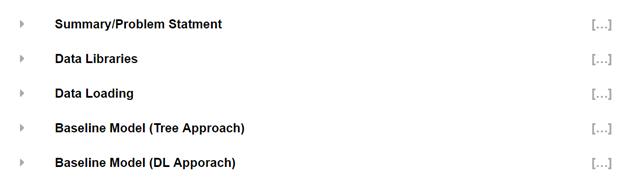
                                                                                                        - Notebook layout
**Step 1 - Clean and prepare your data:** 

The approach that was taken in this challenge was to use the baseline model inform the user what features are important. This inference worked well as it led to the correction of the categorical features seen in the section called 'Fixing Categorical Variables'. With 100 dependent variables, there are many ways to reduce the number of variables. This problem didn’t lead to forcing my hand as the results I received from the baseline approaches were satisfactory. Typically, I will use many methods to reduce the number of variables and a nice implementation is the Recursive Feature Elimination from Sklearn. 

**Step 2 - Build your models:** 

As requested, two different modeling techniques were used to predict the probabilities of the target variable y. The winning approach was a deep learning approach and the second method was a tree-based algorithm.  The reasoning for my methods of approach is the reliability and flexibility of these methods. In my time working in this field I have found the best success in these two domains. There isn’t a golden bullet in Data Science, but there are better and more robust bullets. 

**Step 3 - Generate predictions:**

This is completed, but I have one hesitation on the results, so I am going to be sending a result1.csv and a result1inverse.csv as I am unsure on the way that you want it to be predicting. Both of my models predict 1 when the probability is below the threshold and predicts 0 when above the threshold. The inverse file will be the opposite of that logic. 


**Step 4 - Compare your modeling approaches:**

The modeling techniques used are the most robust techniques that I have discovered in my studies and work. The deep learning approach largest obstacle is getting the environment set up and having the technical hardware to be able to run experiments quickly and efficiently. This obstacle can’t be undervalued if the organization doesn’t have the infrastructure to run deep learning than this model will never make it to production. Another, con of this method is that the data set is small and is going to have a good chance of overfitting to the training data and could lead to poor extrapolation on new data. The pros of this method are that it wasn’t exhaustively regularized, only trained for 3 epochs, and the results on the validation set. One pro that isn’t as obvious is that feature engineering isn’t needed as much when using embeddings. This isn’t to say that results won’t improve with target encoding, interesting feature creation, or even hot encoding rather than label encoding my features. To go about exhaustively on these approaches takes time and thought and this being outside of work project I was limited. 

The second approach is a tree-based algorithm and for more structured data sets I will start with this family of algorithms. The tree-based approach that worked the best for this problem is known as XGBoost. This is a method that has dominated applied machine learning for structured or tabular data. This algorithm isn’t limited to these types of problems, but typically this is where this algorithm shines. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. This is the largest pro of the method is speed and performance. This method outperformed a method called Random Forest and significantly and performed on par with the DL algorithm. Between the two there were only 495 discrepancies between the two models, which is less than five percent of the predicted probabilities. Getting a XGBoost model into production is typically much easier than getting a DL learning model to production. A con of tree-based approaches is the extrapolation on temporal elements as a tree-based approach is splitting the data and will have a hard time with a linear relationship, but it will be captured. 

Overall, these approaches performed very well on the validation set that was the last 8,000 records of the data set. It will be very interesting to see what the results are with the test set and I look forward to conversing about it. Thank you for the consideration of going to State Farm’s Data Science team, and I look forward to bring value to this organization. 

## Data Libraries

In [528]:
#I put this on all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [529]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
from pandas_summary import DataFrameSummary
import seaborn as sns
from rfpimp import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.metrics import classification_report
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn import metrics
import scikitplot as skplt
from xgboost import XGBClassifier
#Peronal Functions created to help with data science problems
from util_functions import *

In [530]:
#util functions if intersted are here    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figsize=None):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore')
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def split_data(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]
    return DataFrameMapper(cat_maps).fit(df), DataFrameMapper(contin_maps).fit(df)

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000): 
            display(df)

def join_df(left, right, left_on, right_on=None, suffix='_y'): 
    if right_on is None: right_on = left_on
    return left.merge(right, how = 'left', left_on=left_on, right_on=right_on, suffixes=("", suffix))

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

## Data Loading

In [550]:
PATH = 'data/'

In [551]:
df_raw = pd.read_csv(f'{PATH}exercise_01_train.csv', low_memory=False)

df_test = pd.read_csv(f'{PATH}exercise_01_test.csv', low_memory=False)

In [552]:
df_raw.shape, df_test.shape

((40000, 101), (10000, 100))

#### Quick Look

 * Let's take a quick look at the data just to see what we are working with. 

In [554]:
display_all(df_raw.head())

x0         x1         x2         x3         x4         x5        x6  \
0  10.142889 -15.675620   3.583176 -22.397489  27.221894 -34.110924 -0.072829   
1 -52.214630   5.847135 -10.902843 -14.132351  20.588574  36.107322  0.115023   
2  67.718500   2.064334  12.394186 -18.667102  47.465504 -50.373658  0.253707   
3 -28.003111   8.565128  -8.592092   5.918960  -3.224154  78.315783 -0.879845   
4  80.703016  30.736353 -30.101857 -21.201140 -91.946233 -47.469246 -0.646831   

         x7        x8        x9       x10       x11        x12       x13  \
0 -0.544444  0.997601 -2.691778 -0.923879  8.109456  27.872550 -3.420582   
1  0.276093 -0.699168 -0.972708  1.287131  5.717183  -3.761334 -5.074973   
2  1.068968  2.939713  2.691218  3.058585  7.537863 -19.130709 -0.906646   
3  1.176889 -2.414752  0.589646 -0.906179  0.087087  25.075633 -0.834239   
4 -0.578398  0.980849 -1.426112  0.363235  5.836213  29.396618 -2.591986   

        x14       x15        x16       x17        x18        x19        x20  \
0  1.511710  6.673493  -4.323289 -1.538177  12.853393 -23.583975 -26.410490   
1 -1.296964 -2.366536 -19.532219 -0.651274  -0.758730  -5.580162  47.151801   
2 -2.794020 -3.978507  14.237849  1.373681   9.635405 -16.183555  16.922392   
3 -0.027757  3.708857 -12.314642  2.700113   7.216934  74.438816  61.764811   
4 -1.555760  4.963425   3.703779 -0.010266  -2.837060  48.985375  23.961394   

        x21        x22        x23        x24        x25       x26        x27  \
0  2.328126 -28.226474  -4.131820   0.268103  -5.661808 -2.782330  30.276359   
1  2.053410  -4.348193 -17.632414  -3.963233 -27.385429  1.991331  25.995571   
2  1.663092  -9.758591 -13.040577 -13.865584   4.965384  0.940166  16.305724   
3 -1.605895 -15.125777   5.556041   4.593257 -16.996278 -3.875344   5.064833   
4  4.685315  21.758491   1.466513  -3.417453  45.498835  4.821398  35.093986   

        x28       x29       x30       x31       x32        x33     x34  \
0 -0.944980  0.277266 -2.233740  0.515763  0.004137 -27.321975     bmw   
1 -1.390032 -0.791795  2.537591 -1.138456 -1.202222  48.491336  nissan   
2  0.112402 -1.199571  1.286813  0.277410  0.682253  -6.741030   Honda   
3 -1.296087  1.630619 -4.694258 -0.722119 -1.689241 -20.987787  Toyota   
4  4.404143  1.387974 -4.123902  2.092002 -0.005312 -65.261291     bmw   

       x35       x36       x37       x38       x39        x40       x41  \
0      wed  5.613605 -8.771422  1.012030 -2.122949   0.500782    $-54.1   
1     thur -2.132043  1.288928 -1.622637 -0.919865   9.054563  $-229.32   
2      wed  3.206642 -8.065741  0.838277 -0.465169   1.225612   $243.68   
3     thur -3.589886  4.368415 -1.045650  1.613660  -4.185118   $126.15   
4  thurday  9.953264  4.303842  0.632836  1.657977  10.945454   $877.39   

          x42        x43         x44     x45       x46        x47       x48  \
0  -60.377200 -14.343129  -38.244485    0.0% -8.346880   0.300698 -3.560418   
1 -280.208298 -46.045485   -7.783574   0.01% -2.248960  15.868349 -2.320347   
2 -119.470071  25.462689   56.571522  -0.01% -2.161725   7.287187 -2.414766   
3  129.270157  13.413693  115.018748   0.02%  4.206076 -40.254305  0.049048   
4 -319.428734   9.194313  -89.678180  -0.02%  1.189501   4.036919  0.296720   

         x49       x50       x51       x52        x53        x54       x55  \
0 -29.858649 -0.004122 -1.034268  2.280323  -9.220175  -0.672959 -1.352266   
1  29.611460  0.035378 -9.960903  0.662594 -40.051587  -7.467978  0.150334   
2 -19.325576  0.865352 -8.971459  0.182888  25.383424  -4.359127 -0.198638   
3  28.853906  0.263934  7.778529  3.748663  -1.119398 -13.652775  0.339680   
4 -34.969908 -0.490233 -2.936929  1.080471  15.078833   6.662614  0.411686   

         x56        x57        x58       x59       x60        x61       x62  \
0  19.547038  -6.706483 -16.123533 -5.271198  0.099280  -4.905632  0.557732   
1  13.798547 -19.627385 -28.046366 -8.330669  0.014509  -3.445528  0.109443   
2   3.231385 -34.887447 -19.61786

|Categorical Variables: |
| --- | 
| x34 == Type of Car (Feature Possible Quality of Car)|
| x35 == DOW |
| x41 == $ Amount (Change to a Numeric Variable by Fixing) |
| x45 == % of some sort (Change to a Numeric Variable) |
| x68 == Month |
| x93 == Country (Reduce dimensionality)  |



In [555]:
display_all(DataFrameSummary(df_raw).summary())

x0       x1       x2        x3        x4       x5  \
count           39986    39990    39994     39990     39994    39990   
mean          8.25996 -3.24979  1.03067 -0.747566   0.28382 -1.77351   
std           38.3742  15.1711  24.7322   15.2257     42.24  42.1241   
min           -140.78 -64.4939 -105.388  -63.8049  -158.196 -169.237   
25%          -17.8002 -13.4586 -15.5655  -11.0783  -28.2465 -30.3914   
50%           8.35466  -3.3866  1.13299 -0.714888  0.292788 -1.75337   
75%           33.8298  6.88166  17.6776    9.5524   28.7197  26.8448   
max           177.399  62.9068  99.3949   59.3384   179.343  170.894   
counts          39986    39990    39994     39990     39994    39990   
uniques         39986    39990    39994     39990     39994    39990   
missing            14       10        6        10         6       10   
missing_perc    0.03%    0.03%    0.01%     0.03%     0.01%    0.03%   
types         numeric  numeric  numeric   numeric   numeric  numeric   

                       x6          x7        x8        x9       x10  \
count               39993       39987     39994     39993     39992   
mean         -0.000232164  -0.0161069 -0.651093 -0.014688   0.28044   
std               1.06596     3.38264   2.94747    1.9065   1.50394   
min              -4.13349     -12.967  -12.0376   -7.4462  -6.34568   
25%             -0.723098    -2.29908  -2.62886  -1.29976 -0.721282   
50%            0.00110535 -0.00355648 -0.659223  -0.02817  0.283863   
75%              0.715844     2.25997    1.3221   1.26347   1.29122   
max               5.31165     16.6194   14.9949   7.30019    6.4988   
counts              39993       39987     39994     39993     39992   
uniques             39993       39987     39994     39993     39992   
missing                 7          13         6         7         8   
missing_perc        0.02%       0.03%     0.01%     0.02%     0.02%   
types             numeric     numeric   numeric   numeric   numeric   

                     x11      x12        x13          x14        x15  \
count              39991    39989      39987        39997      39992   
mean           0.0128993 -7.52695 -0.0059131   0.00265716  0.0395057   
std              6.44765  30.0071    2.98022      1.69984    8.92385   
min             -25.8354 -130.029   -12.7001     -7.00507   -34.9536   
25%             -4.31998 -27.6318   -2.01964     -1.13236   -5.98017   
50%           0.00435476 -7.49277 -0.0143454 -0.000651829  0.0628124   
75%              4.34149  12.5858    2.02526      1.14401    6.05554   
max              24.3946  118.676    12.2799      7.01913    40.0698   
counts             39991    39989      39987        39997      39992   
uniques            39991    39989      39987        39997      39992   
missing                9       11         13            3          8   
missing_perc       0.02%    0.03%      0.03%        0.01%      0.02%   
types            numeric  numeric    numeric      numeric    numeric   

                     x16         x17      x18       x19      x20       x21  \
count              39992       39989    39986     39992    39994     39987   
mean           -0.015456 -0.00487207  1.64949   0.13367  7.30741  0.317232   
std              9.85239     2.28222  6.65447   35.8017  38.4283   1.72317   
min             -42.9457    -8.94856 -25.1411   -145.53 -170.224  -7.01758   
25%             -6.67156    -1.54479  -2.8065  -24.1403 -18.5241 -0.843703   
50%          -0.00169125 -0.00414502  1.67633 -0.189974  7.09698  0.324949   
75%              6.65333     1.54513  6.12486   24.0558  33.0783   1.47085   
max              35.9086     8.82279  26.1035   147.739  167.883   7.56907   
counts             39992       39989    39986     39992    39994     39987   
uniques            39992       39989    39986     39992    39994     39987   
missing                8          11       14         8        6        13   
missing_perc       0.02%       0.03%    0.03%     0.02%    0.01%     0

In [556]:
#Only Missing Data Information
display_all(missing_data(df_raw))

x0       x1       x2       x3       x4       x5       x6  \
Total         14       10        6       10        6       10        7   
Percent    0.035    0.025    0.015    0.025    0.015    0.025   0.0175   
Types    float64  float64  float64  float64  float64  float64  float64   

              x7       x8       x9      x10      x11      x12      x13  \
Total         13        6        7        8        9       11       13   
Percent   0.0325    0.015   0.0175     0.02   0.0225   0.0275   0.0325   
Types    float64  float64  float64  float64  float64  float64  float64   

             x14      x15      x16      x17      x18      x19      x20  \
Total          3        8        8       11       14        8        6   
Percent   0.0075     0.02     0.02   0.0275    0.035     0.02    0.015   
Types    float64  float64  float64  float64  float64  float64  float64   

             x21      x22      x23      x24      x25      x26      x27  \
Total         13        5        9       11        8       11        8   
Percent   0.0325   0.0125   0.0225   0.0275     0.02   0.0275     0.02   
Types    float64  float64  float64  float64  float64  float64  float64   

             x28      x29      x30      x31      x32      x33     x34     x35  \
Total         11        5        5        8        4        9       7      10   
Percent   0.0275   0.0125   0.0125     0.02     0.01   0.0225  0.0175   0.025   
Types    float64  float64  float64  float64  float64  float64  object  object   

             x36      x37      x38      x39      x40     x41      x42  \
Total          7        3        6        8        6       5       12   
Percent   0.0175   0.0075    0.015     0.02    0.015  0.0125     0.03   
Types    float64  float64  float64  float64  float64  object  float64   

             x43      x44     x45      x46      x47      x48      x49  \
Total          1        4       5        7        4       10        6   
Percent   0.0025     0.01  0.0125   0.0175     0.01    0.025    0.015   
Types    float64  float64  object  float64  float64  float64  float64   

             x50      x51      x52      x53      x54      x55      x56  \
Total          5       11        8        4        6       14       11   
Percent   0.0125   0.0275     0.02     0.01    0.015    0.035   0.0275   
Types    float64  float64  float64  float64  float64  float64  float64   

             x57      x58      x59      x60      x61      x62      x63  \
Total          8        7        9       12        6       13       13   
Percent     0.02   0.0175   0.0225     0.03    0.015   0.0325   0.0325   
Types    float64  float64  float64  float64  float64  float64  float64   

             x64      x65      x66      x67     x68      x69      x70  \
Total          5       12       10        8       9       13        4   
Percent   0.0125     0.03    0.025     0.02  0.0225   0.0325     0.01   
Types    float64  float64  float64  float64  object  float64  float64   

             x71      x72      x73      x74      x75      x76      x77  \
Total          4        8        6        7       10        7       10   
Percent     0.01     0.02    0.015   0.0175    0.025   0.0175    0.025   
Types    float64  float64  float64  float64  float64  float64  float64   

             x78      x79      x80      x81      x82      x83      x84  \
Total          7        9        7        5        7        5        3   
Percent   0.0175   0.0225   0.0175   0.0125   0.0175   0.0125   0.0075   
Types    float64  float64  float64  float64  float64  float64  float64   

             x85      x86      x87      x88      x89      x90      x91  \
Total         12        9        7        4       10        7        2   
Percent     0.03   0.0225   0.0175     0.01    0.025   0.0175    0.005   
Types    float64  float64  float64  float64  float64  float64  float64   

             x92     x93      x94      x95      x96      x97      x98  \
Total          6       7       11        7       15        7    

We can either leave noisy or outlier records as-is, delete, or “fix” the records, but the error is to lean on the side of leaving records as-is. Not knowing anythinga about this data set makes this extremely difficult to know what to do. The knowledge about this domain, the goals of the model, how numerous the anomalies are, and even what we see in the individual records with anomalous values.

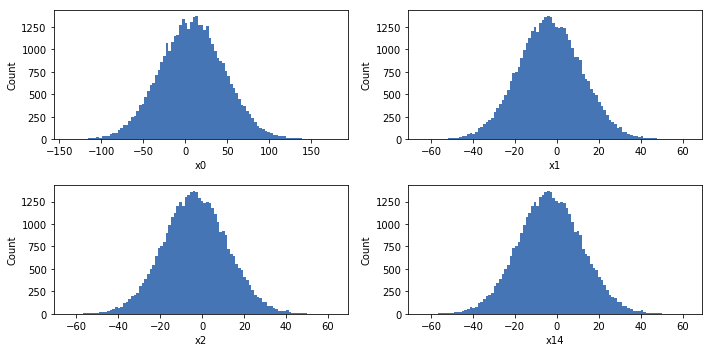

In [557]:
fig, axes = plt.subplots(2,2,figsize=(10,5)) # 1 row, 2 columns
axes[0,0].hist(df_raw.x0, color='#4575b4', bins=100)
axes[0,0].set_ylabel("Count")
axes[0,0].set_xlabel("x0")

axes[0,1].hist(df_raw.x1, color='#4575b4', bins=100)
axes[0,1].set_ylabel("Count")
axes[0,1].set_xlabel("x1")
plt.tight_layout()

axes[1,0].hist(df_raw.x1, color='#4575b4', bins=100)
axes[1,0].set_ylabel("Count")
axes[1,0].set_xlabel("x2")
plt.tight_layout()

axes[1,1].hist(df_raw.x1, color='#4575b4', bins=100)
axes[1,1].set_ylabel("Count")
axes[1,1].set_xlabel("x14")
plt.tight_layout()
plt.show()

In [558]:
cols = [c for c in df_raw.columns];
print('Number of Features: {}'.format(len(cols)))
print('Feature Types:')
df_raw[cols].dtypes.value_counts()

Number of Features: 101
Feature Types:


float64    94
object      6
int64       1
dtype: int64

 * We can make a few observations here, but as a general practice, I try and avoid looking to much at the data values. It's temptation to make judgments or prematurely manipulating the data based upon human observations. This is what machine learning, the best example is seeing a lot of missing values in a column and remove them from condiserdation. I am a believer of letting the model tell us what is important. 

    1. The missing data seems to very low, but we know this from the problem statement stating data was removed to make "dirty" data better known as real data in the real world. 
         - Very little imputation will be done on this because missing data in real world scenarios are very important and typically creates its own class. There is typically reason the data is missing and our algorithms will pick up on this and can become a very important feature. 

    2. Why is there so many unique fields binning fields might be the option to go about, but until we model we won't know if that is something worth doing.  
  
    3. The data comes from a temporal data set as one sees DOW, MONTH, etc in the data. The data seems to be more numerical than categorical, but with out a proper data dictionary blind EDA will be time consuming. 
    
        - The approach that I will be taking is Modeling inference and I will be using a RDF to tell me what variables are important and if features need to be created. 

Text(0.5, 1.0, 'Distribution of Target Variable')

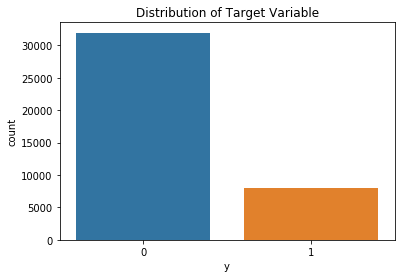

In [12]:
#Distribution of Target Variable
sns.countplot(df_raw['y'])
plt.title('Distribution of Target Variable')

In [13]:
print("{}% of the training data with the value 1 for the Target".format(round(100 * df_raw["y"].value_counts()[1]/df_raw.shape[0]),2))

20.0% of the training data with the value 1 for the Target


In [14]:
#Simple way to look
pd.value_counts(df_raw['y'], normalize=True)

0    0.798825
1    0.201175
Name: y, dtype: float64

This is an unbalanced data set with the respect to the **Target** for now nothing is going to be done about this, but will be looked into later in the analysis

In [15]:
#Duplicates? 
df_dup = df_raw[df_raw.duplicated(keep=False)]

In [16]:
#None In the data set
df_dup.shape

(0, 101)

In [203]:
%%time
features = df_raw.columns.values[0:99]
unique_max_train = []
for feature in features:
    values = df_raw[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 191 ms


In [204]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

93     35     45          34     68       41       0   \
Feature           x93    x35    x45         x34    x68      x41       x0   
Max duplicates  35409  20725  19091       12572  11088        5        1   
Value            asia    wed   0.01  volkswagon    jul  9999.12 -26.4412   

                     64        71       70       69       67       66  \
Feature             x64       x71      x70      x69      x67      x66   
Max duplicates        1         1        1        1        1        1   
Value          -1.04571  0.822037  1.06205 -23.8988  7.32232 -61.0459   

                      65       62  
Feature              x65      x62  
Max duplicates         1        1  
Value           0.788456 -3.52327

Asia has a huge presence in this data set. Along with wed and volkswagon. I will have to think about what I can do with that information.

#### Fixing Categorical Variables 

There may be other things to fix, but for now I want to make it to modeling inference based EDA

In [559]:
value = 9999.123
#Fixing missing to fix the categorical variable 
df_raw['x41'] = df_raw['x41'].fillna(value)
df_raw['x45'] = df_raw['x45'].fillna(value)
#Change x41 $ amount to a numeric 
df_raw.x41 = df_raw.x41.replace('[\$,]', '', regex=True).astype(float)
#More robust approach (Remove all non-digits and decimals [^.0-9]
df_raw.x45 = df_raw.x45.replace('[^.0-9]', '', regex=True).astype(float)
#To make sure we don't lose the null values 
df_raw.loc[df_raw.x41 == 9999.000, 'x41'] = np.NaN
df_raw.loc[df_raw.x45 == value, 'x45'] = np.NaN

In [560]:
value = 9999.123
#Fixing missing to fix the categorical variable 
df_test['x41'] = df_test['x41'].fillna(value)
df_test['x45'] = df_test['x45'].fillna(value)
#Change x41 $ amount to a numeric 
df_test.x41 = df_test.x41.replace('[\$,]', '', regex=True).astype(float)
#More robust approach (Remove all non-digits and decimals [^.0-9]
df_test.x45 = df_test.x45.replace('[^.0-9]', '', regex=True).astype(float)
#To make sure we don't lose the null values 
df_test.loc[df_test.x41 == 9999.000, 'x41'] = np.NaN
df_test.loc[df_test.x45 == value, 'x45'] = np.NaN

**Note this was noticed through model inference**

Looking at important variables DOW made the list and this is when the spelling was found to be a problem. 

The idea behind fixing it was to lower all the categorical variables and then only take the first 3 letters of each day if there were to be other issues out side of this fix than we would look to fix that as a company. This is a good example of having free text compared to a drop down menu. 

In [561]:
cat_vars = ['x35','x34','x93','x68']

In [562]:
for c in cat_vars: 
    df_raw[c] = df_raw[c].astype('str')
    df_raw[c] = [x.lower() for x in df_raw[c]]
    df_test[c] = df_test[c].astype('str')
    df_test[c] = [x.lower() for x in df_test[c]]

In [563]:
#This isn't want we want to do, but this is what we have to do
df_raw['x68'] = df_raw['x68'].str.replace('dev', 'dec')
df_test['x68'] = df_test['x68'].str.replace('dev', 'dec')

In [564]:
def first3(s):
    return s[:3]

In [565]:
df_raw['x35'] = df_raw.loc[:,'x35'].apply(first3)
df_test['x35'] = df_test.loc[:,'x35'].apply(first3)
df_raw['x68'] = df_raw.loc[:,'x68'].apply(first3)
df_test['x68'] = df_test.loc[:,'x68'].apply(first3)

In [566]:
for c in cat_vars: 
    df_raw[c] = df_raw[c].replace('nan', np.nan)

#### Pair Plot 

In [290]:
x = df_raw.dtypes
find_cats = pd.DataFrame({'Type':x})
cats = find_cats.loc[find_cats.Type == 'object']
cats.index.values

array(['x34', 'x35', 'x68', 'x93'], dtype=object)

In [ ]:
x = df_raw.dtypes
find_cats = pd.DataFrame({'Type':x})
cats = find_cats.loc[find_cats.Type == 'object']
cats.index.values

In [289]:
cat_vars = ['x34', 'x35', 'x68', 'x93']
cont_vars = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11', 'x12', 'x13', 'x14', 'x15', 
               'x16', 'x17', 'x18', 'x19','x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28','x29', 'x30',
               'x31', 'x32', 'x33', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 
               'x46','x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55','x56', 'x57', 'x58', 'x59', 'x60',
               'x61', 'x62', 'x63', 'x64','x65', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73','x74', 'x75', 
               'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82','x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90',
               'x91','x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99']

df_wcontin = df_raw[['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11', 'x12', 'x13', 'x14', 'x15', 
               'x16', 'x17', 'x18', 'x19','x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28','x29', 'x30',
               'x31', 'x32', 'x33', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 
               'x46','x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55','x56', 'x57', 'x58', 'x59', 'x60',
               'x61', 'x62', 'x63', 'x64','x65', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73','x74', 'x75', 
               'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82','x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90',
               'x91','x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'y']]

/home/jdemlow/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jdemlow/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


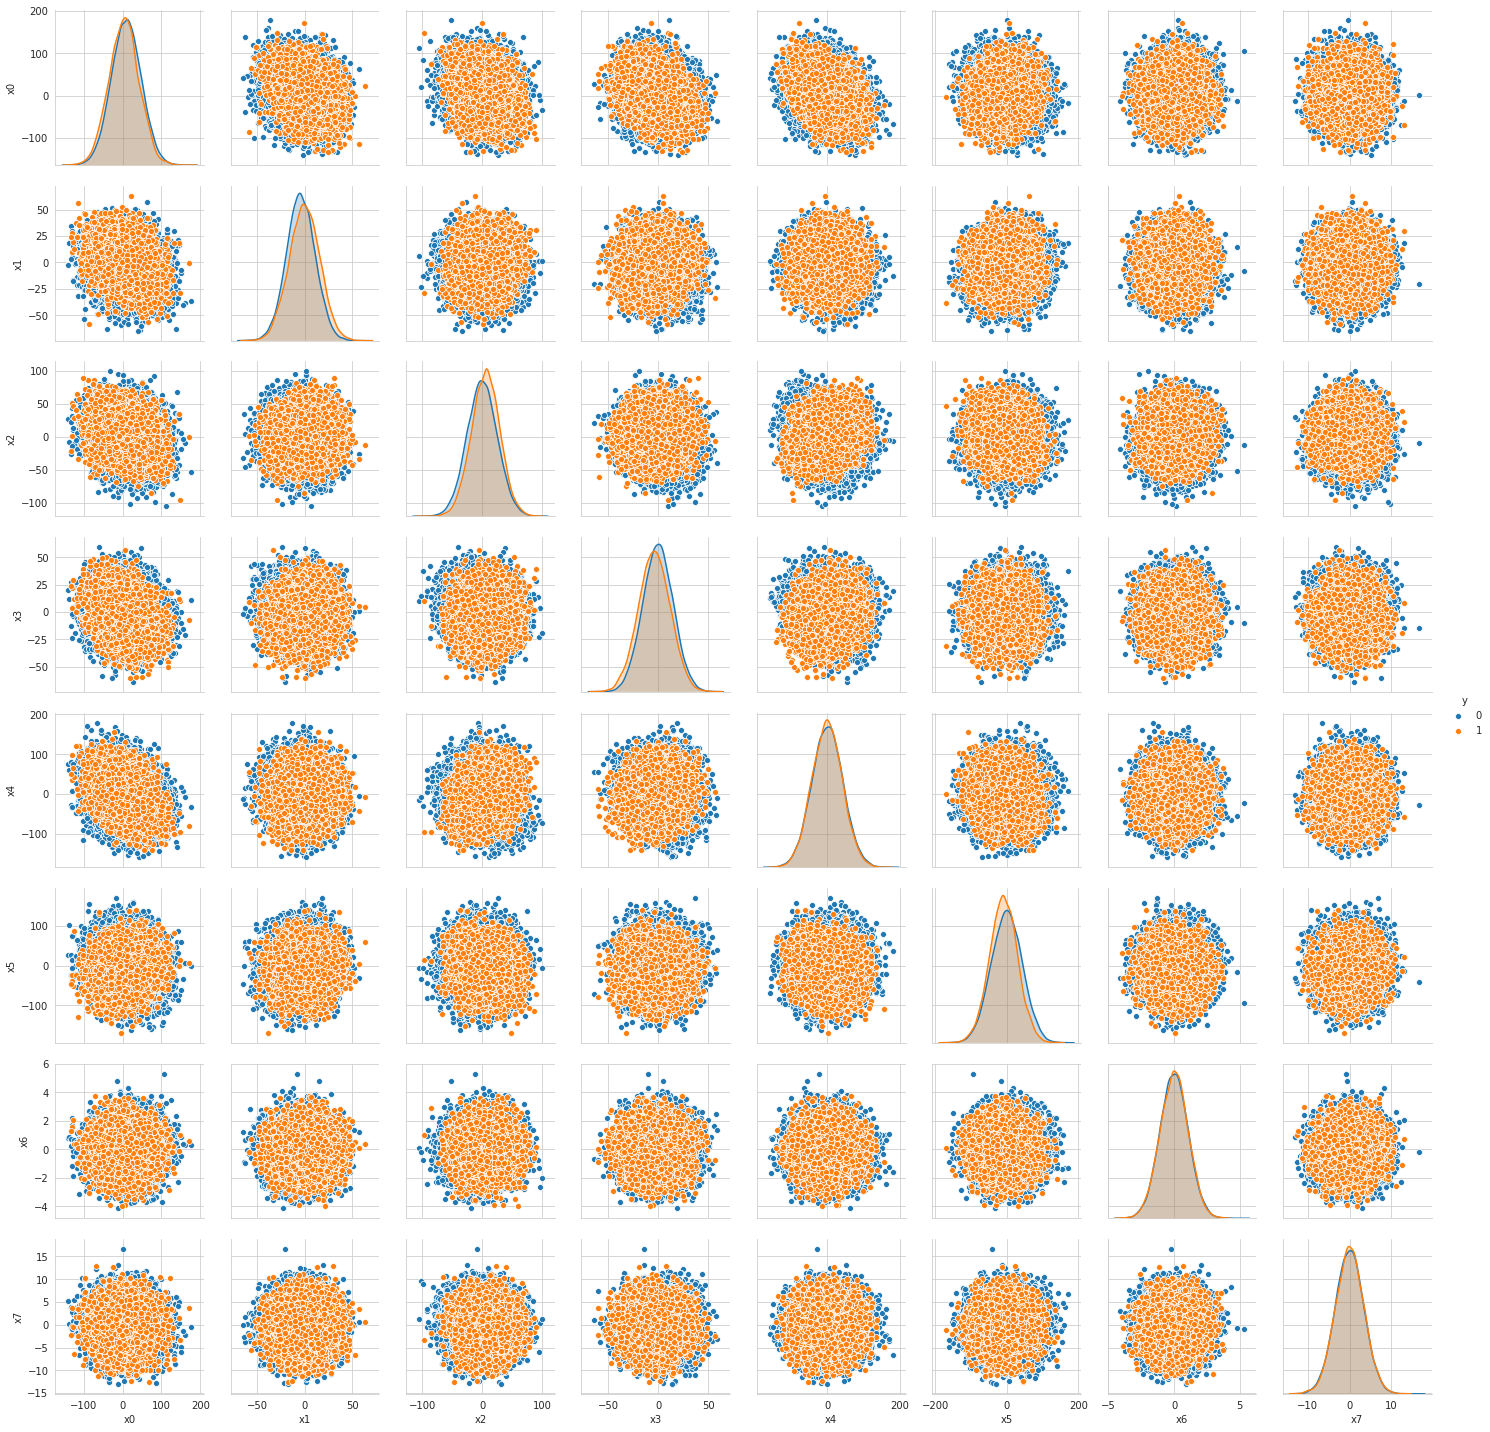

In [31]:
features = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
target = "y"

sns.pairplot(df_wcontin, vars=features, hue="y")

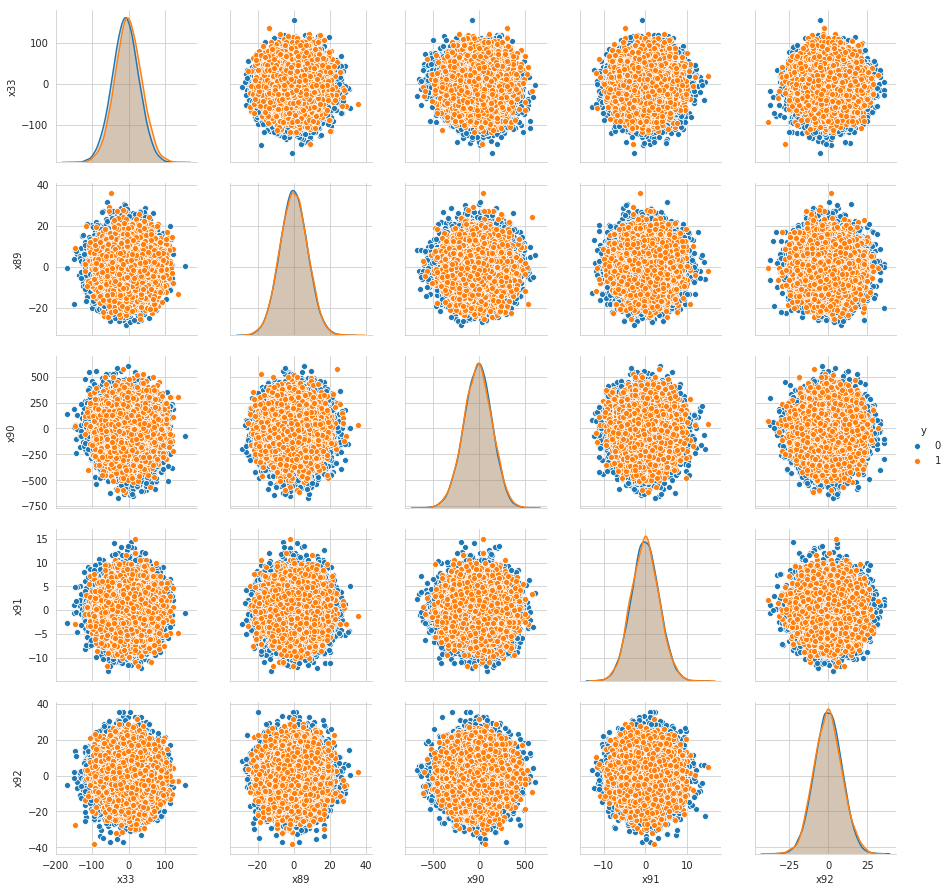

In [32]:
#Features that didn't work in density or were interesting
features = ['x33', 'x89', 'x90', 'x91', 'x92']
target = "y"

sns.pairplot(df_wcontin, vars=features, hue="y")

From the density and pairplots we are seeing some seperation in the numeric columns, but let's dig a little deeper once we have a baseline model going.

## Baseline Model (Tree Approach)

**Wish List**

- Tree Based Approaches (Random Forest & Xgboost (No time to implement Cat or LGB))
    - Baseline/Different Split Methods
    - Variable Importance Performance of Model & Pruning of Features
    - Hyper Tune Baseline and Cross Validate
    - Feature Engineering from Model Inference (Time Pending)
    - Evaluate Features (Time Pending)
    -  XGB same steps as above (Time Pending)
    - Hyper Tune Through a Randomized Search 

### Random Forest 

In [342]:
df = df_raw.copy()

In [343]:
display_all(missing_data(df))

x0       x1       x2       x3       x4       x5       x6  \
Total         14       10        6       10        6       10        7   
Percent    0.035    0.025    0.015    0.025    0.015    0.025   0.0175   
Types    float64  float64  float64  float64  float64  float64  float64   

              x7       x8       x9      x10      x11      x12      x13  \
Total         13        6        7        8        9       11       13   
Percent   0.0325    0.015   0.0175     0.02   0.0225   0.0275   0.0325   
Types    float64  float64  float64  float64  float64  float64  float64   

             x14      x15      x16      x17      x18      x19      x20  \
Total          3        8        8       11       14        8        6   
Percent   0.0075     0.02     0.02   0.0275    0.035     0.02    0.015   
Types    float64  float64  float64  float64  float64  float64  float64   

             x21      x22      x23      x24      x25      x26      x27  \
Total         13        5        9       11        8       11        8   
Percent   0.0325   0.0125   0.0225   0.0275     0.02   0.0275     0.02   
Types    float64  float64  float64  float64  float64  float64  float64   

             x28      x29      x30      x31      x32      x33     x34     x35  \
Total         11        5        5        8        4        9       7      10   
Percent   0.0275   0.0125   0.0125     0.02     0.01   0.0225  0.0175   0.025   
Types    float64  float64  float64  float64  float64  float64  object  object   

             x36      x37      x38      x39      x40      x41      x42  \
Total          7        3        6        8        6        0       12   
Percent   0.0175   0.0075    0.015     0.02    0.015        0     0.03   
Types    float64  float64  float64  float64  float64  float64  float64   

             x43      x44      x45      x46      x47      x48      x49  \
Total          1        4        5        7        4       10        6   
Percent   0.0025     0.01   0.0125   0.0175     0.01    0.025    0.015   
Types    float64  float64  float64  float64  float64  float64  float64   

             x50      x51      x52      x53      x54      x55      x56  \
Total          5       11        8        4        6       14       11   
Percent   0.0125   0.0275     0.02     0.01    0.015    0.035   0.0275   
Types    float64  float64  float64  float64  float64  float64  float64   

             x57      x58      x59      x60      x61      x62      x63  \
Total          8        7        9       12        6       13       13   
Percent     0.02   0.0175   0.0225     0.03    0.015   0.0325   0.0325   
Types    float64  float64  float64  float64  float64  float64  float64   

             x64      x65      x66      x67     x68      x69      x70  \
Total          5       12       10        8       9       13        4   
Percent   0.0125     0.03    0.025     0.02  0.0225   0.0325     0.01   
Types    float64  float64  float64  float64  object  float64  float64   

             x71      x72      x73      x74      x75      x76      x77  \
Total          4        8        6        7       10        7       10   
Percent     0.01     0.02    0.015   0.0175    0.025   0.0175    0.025   
Types    float64  float64  float64  float64  float64  float64  float64   

             x78      x79      x80      x81      x82      x83      x84  \
Total          7        9        7        5        7        5        3   
Percent   0.0175   0.0225   0.0175   0.0125   0.0175   0.0125   0.0075   
Types    float64  float64  float64  float64  float64  float64  float64   

             x85      x86      x87      x88      x89      x90      x91  \
Total         12        9        7        4       10        7        2   
Percent     0.03   0.0225   0.0175     0.01    0.025   0.0175    0.005   
Types    float64  float64  float64  float64  float64  float64  float64   

             x92     x93      x94      x95      x96      x97      x98  \
Total          6       7       11        7       15     

In [344]:
df.shape

(40000, 101)

#### Splitting This Data Set

- From looking at the data there doesn't seem to be a temporal element to be to worried about here and a random stratification on the target variable will be the split that I use for the baseline

- A classic 80/20 split will be done first

- Missing data will be given the median value of the column if it isn't known it will be kept as 

In [345]:
#label encoding categorical variables 
train_cats(df)

In [23]:
#This split_data (prepares data for being split and scaling, imputation)
df_trn, y_trn, nas, mapper = split_data(df, 'y', do_scale=True)

value_20_80 = int(len(df)*.20)

def split_vals(a,n): return a[:n], a[n:]
n_valid = value_20_80
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

In [26]:
pd.value_counts(y_train, normalize=True)

0    0.799594
1    0.200406
dtype: float64

In [27]:
pd.value_counts(y_valid, normalize=True)

0    0.79575
1    0.20425
dtype: float64

We will see that there is a slight difference in the split when using sklearn below is an example of using sklearn split method. 

#### Baseline Model

There isn't a need to keep the proportions the same as the distrubtion seems to be evenly distrubted between the validation and training set. 

 - An example of this would be a pt id or a customer id where we might want to keep them seperated and only in one of the splits because we don't want out model to learn customers or patients, but the variance between the dependent variables

In [28]:
#manual split
m = RandomForestClassifier(n_jobs= -1, oob_score=True)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

CPU times: user 2.29 s, sys: 48.1 ms, total: 2.34 s
Wall time: 425 ms
Training Acc: 0.98947
Validation Acc: 0.85012
Out-of-Bag Acc: 0.83178


Overfitting is very apparent here & as you can see the method from Sklearn and the Mannual method seems to make litte difference. The mannual method might be a better apporach as typical query data is in some sort of time structured manner and taking advantage of that is critical. 

#### Performance of Model

In [29]:
preds = m.predict(X_valid)

In [91]:
probs = m.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)

Text(0, 0.5, 'True Postive Rate')

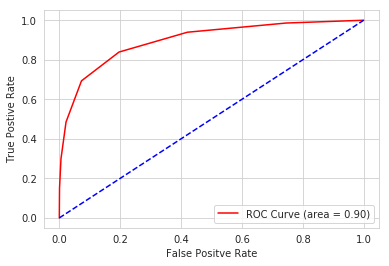

In [92]:
plt.plot(fpr, tpr, color = 'red', label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'blue', linestyle = '--')
plt.legend(loc ="lower right")
plt.xlabel('False Positve Rate')
plt.ylabel('True Postive Rate')

Below is a great library that allows nice pictures of the model's performance and is typically what I will use in my day to day evaluation. 

In [93]:
probs = m.predict_proba(X_valid)

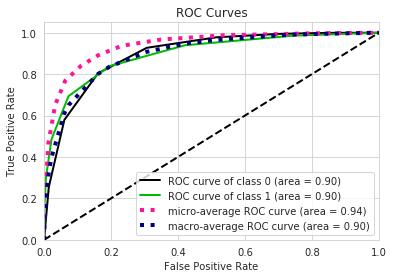

In [94]:
skplt.metrics.plot_roc(y_valid, probs);plt.show()

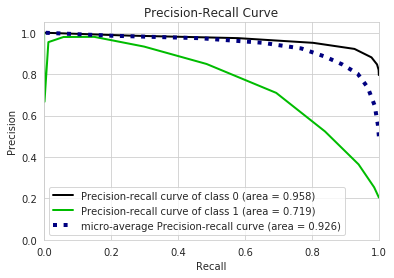

In [95]:
skplt.metrics.plot_precision_recall(y_valid, probs);plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

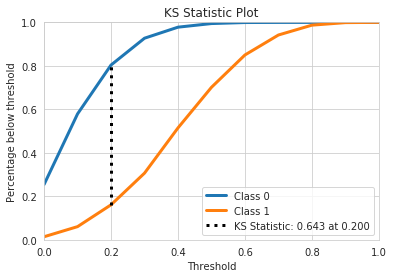

In [96]:
skplt.metrics.plot_ks_statistic(y_valid, probs); plt.show

<function matplotlib.pyplot.show(*args, **kw)>

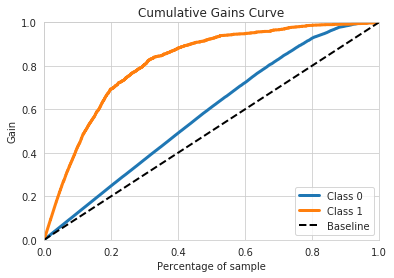

In [97]:
skplt.metrics.plot_cumulative_gain(y_valid, probs); plt.show

Accuracy Score Per Class


array([0.84672997, 0.93307839])

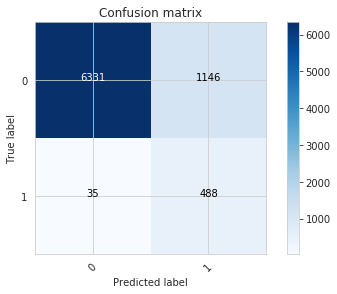

In [98]:
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
cm.diagonal()/cm.sum(axis=1)

In [99]:
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      6366
           1       0.93      0.30      0.45      1634

   micro avg       0.85      0.85      0.85      8000
   macro avg       0.89      0.65      0.68      8000
weighted avg       0.86      0.85      0.82      8000



In [100]:
# https://en.wikipedia.org/wiki/Precision_and_recall
# also just to show the math behind these metrics
tp = ((probs.argmax(1) == 1) * y_valid).sum()
tn = ((probs.argmax(1) == 0) * (y_valid==0)).sum()
fn = ((probs.argmax(1) == 0) * y_valid).sum()
fp = ((probs.argmax(1) == 1) * (y_valid==0)).sum()

The Classifer picks up on a Target == 1: .30% of the time, which is a 10% increase to the distrubtion

In [ ]:
# Recall of target == 1
tp/(tp+fn)

Out of all the observations it identifies as 1, 93% are actual 1

In [102]:
#precision
tp/(tp+fp)

0.9330783938814532

In [103]:
errors = []
print(f"Validation ROC Score trials:", end='')
for i in range(7):
    n_valid = value_20_80
    n_trn = len(df_trn)-n_valid
    X_train, X_valid = split_vals(df_trn, n_trn)
    y_train, y_valid = split_vals(y_trn, n_trn)
    raw_train, raw_valid = split_vals(df, n_trn)
    m = RandomForestRegressor(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    e = roc_auc_score(y_valid, preds)
    print(f"{e:.2f}", end='')
    errors.append(e)
print()
noisy_avg_roc = np.mean(errors)
print(f"Average validation ROC Score {noisy_avg_roc:.2f}")

Validation ROC Score trials:0.910.910.910.910.910.900.91
Average validation ROC Score 0.91


In [104]:
errors = []
print(f"Validation log_loss trials:", end='')
for i in range(7):
    n_valid = value_20_80
    n_trn = len(df_trn)-n_valid
    X_train, X_valid = split_vals(df_trn, n_trn)
    y_train, y_valid = split_vals(y_trn, n_trn)
    raw_train, raw_valid = split_vals(df, n_trn)
    m = RandomForestRegressor(n_jobs=-1)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    e = log_loss(y_valid, preds)
    print(f"{e:.2f}", end='')
    errors.append(e)
print()
noisy_avg_roc = np.mean(errors)
print(f"Average validation log_loss {noisy_avg_roc:.2f}")

Validation log_loss trials:0.450.460.450.470.480.410.40
Average validation log_loss 0.45


The results seems to be pretty consistent here and this is a pretty strong performance when looking at the ROC_Score that is what this problem is being evaluated on. What needs to be fixed is the recall and that will be where hypertuning/EDA/Feature_eng will com into play. 

#### A Wrong Prediction Example

- Just an example of seeing where this model is confident, but wrong

In [80]:
np.set_printoptions(precision=3)
target_values = range(2)
probs = m.predict_proba(X_valid)
prob_for_1_target = probs[2]
print(prob_for_1_target)
print(y_valid[2])
print(probs[2].argmax())

[0.7 0.3]
1
0


In [75]:
pred_digit = np.argmax(prob_for_1_target)
print("predicted digit is", pred_digit)

predicted digit is 0


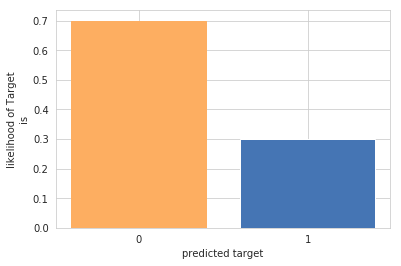

In [76]:
pred_digit = np.argmax(prob_for_1_target)
bars = plt.bar(target_values, prob_for_1_target, color='#4575b4')
bars[pred_digit].set_color('#fdae61')
plt.xlabel("predicted target")
plt.xticks(target_values)
plt.ylabel("likelihood of Target\nis")
plt.show()

The baseline model is working decently we would like to see recall at a much better score, but for a baseline this model seems to be doing very well. Before model inference happens I am going to hypertune a couple of the hyperparamters. We also see that our model can be very confident when predicting and be wrong. 

#### What is Driving This Model? 

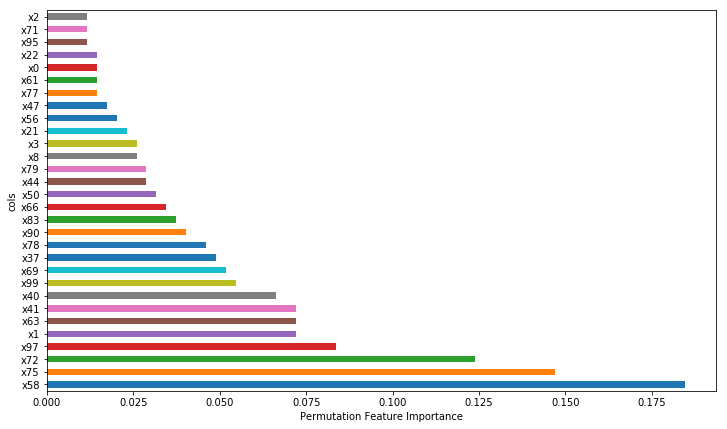

In [30]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, X_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:30], False, 'Permutation')

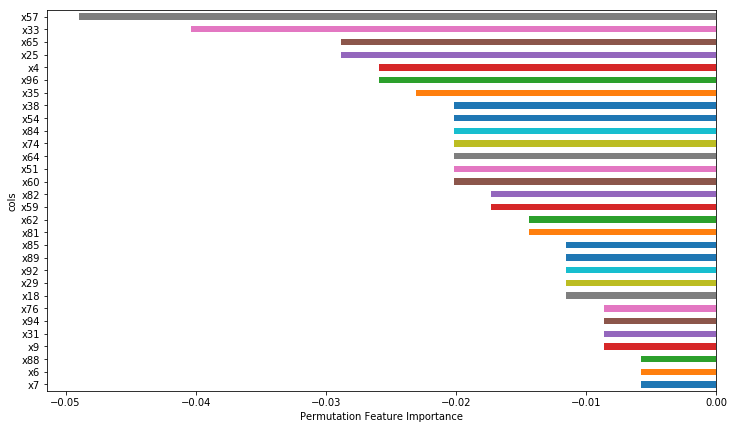

In [31]:
plot_fi(fi_permutation[-30:], False, 'Permutation')

We see that our model has vairables that are leading to negative importance the reason could be a lot of things, but when working with tree algo, we are going to see greedy algos lead to splitting of importance between variables. There are methods that would allow myself to see what they bring together. A great example of lat and long that would be two columns that should be looked at together. This will not be shown in this challenge as I don't know what x_digits are. 

#### Single Tree

This Model is over fitting does a simple decision tree do this as well? This was just a check and to see if tuning would help and you will see that it does. 

In [127]:
#Sanity Check
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))

CPU times: user 681 ms, sys: 8.02 ms, total: 689 ms
Wall time: 726 ms
Training Acc: 0.13252
Validation Acc: 0.1291


In [131]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))

Training Acc: 1.0
Validation Acc: -0.09055


#### Variable Reduction

In [32]:
to_keep = fi_permutation[fi_permutation.imp > 0.005].cols; len(to_keep) 

47

In [33]:
pwd

'/home/jdemlow/fastai/course-v3/nbs/dl1/statefarm'

In [34]:
to_keep.to_csv('first_reduction_columns.csv', index=False)

In [35]:
first_reduction_columns = pd.read_csv('first_reduction_columns.csv', header=None);

We see that more than half of our variables were taken out of this method. This is a method of choice for me to find what variables are important. There are many methods on doing this, but this is my go to, but another method that is nice is implemented in sklearn called `Recursive feature elimination`

In [36]:
x_valid = X_valid[to_keep].copy()
x_train = X_train[to_keep].copy();

x_train.shape, x_valid.shape

((32000, 47), (8000, 47))

In [37]:
m = RandomForestClassifier(n_jobs= -1, oob_score=True)
%time m.fit(x_train, y_train)
print("Training Acc:", round(m.score(x_train, y_train),5)),
print("Validation Acc:", round(m.score(x_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 233 ms
Training Acc: 0.99181
Validation Acc: 0.86938
Out-of-Bag Acc: 0.84669


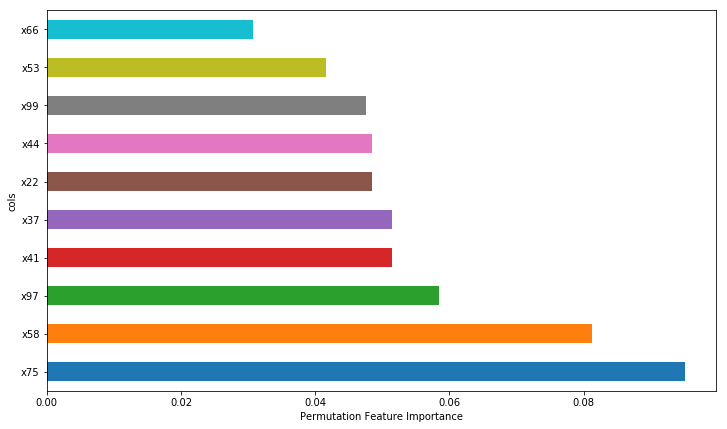

In [38]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, x_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

In [39]:
fi_permutation[-10:]

cols       imp
37  x27  0.003960
38  x98  0.001980
39  x68  0.000990
40  x14  0.000990
41  x91 -0.000990
42  x42 -0.002970
43  x71 -0.003960
44  x87 -0.004950
45  x39 -0.005941
46  x32 -0.009901

We still see some negative cols this would still remove another 10 variables and again this will be check if this leads to improvement of the model 

Slight deviation in the important variables. 

- x75 is leading the back and some investigation will need to be done on this variable. 

- x41 with the std of 100+ with out scaling is also in the top 10 variables leading this model type. 

    - This is the dollar amount variable, this is a state farm problem it's probably okay to assume this is some type of claim or insurance data set. Feature to create (neg / pos) (percentile loss and gain)

- EDA on the top 10 variables will most likely need to be done and features if possible will be created with those. 

    - Note features of DOW there will be weekday or weekend
    - Month Season type (Winter, Spring, Summer, Fall) 
    - Cars (Luxury or Cheap) (USA or Foriegn) 

Accuracy Score Per Class
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6366
           1       0.92      0.40      0.55      1634

   micro avg       0.87      0.87      0.87      8000
   macro avg       0.89      0.69      0.74      8000
weighted avg       0.88      0.87      0.85      8000



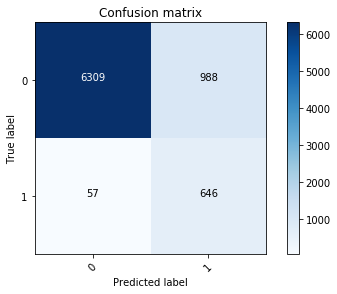

In [40]:
preds = m.predict(x_valid)
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
cm.diagonal()/cm.sum(axis=1)
print(classification_report(y_valid, preds))

**Before Reduction**

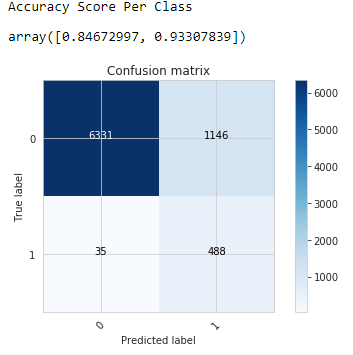

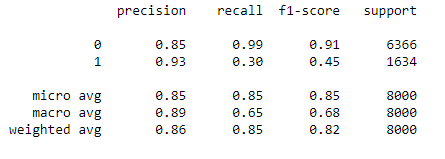

My goal is to increase recall all other metrics are great so this below is what we are looking to do. Everything increased so this is exactly what we want and will continue to do so

As you can see there is a large performance increase and this is the bias/variance trade off and as a data scientist we have to make these types of decisions. 

In [41]:
#Further Reduction
to_keep = fi_permutation[fi_permutation.imp > 0.005].cols; len(to_keep) 

36

In [42]:
to_keep.to_csv('second_reduction_columns.csv', index=False)

second_reduction_columns = pd.read_csv('second_reduction_columns.csv', header=None);

In [43]:
x_valid = X_valid[to_keep].copy()
x_train = X_train[to_keep].copy();

x_train.shape, x_valid.shape

((32000, 36), (8000, 36))

In [44]:
m = RandomForestClassifier(n_jobs= -1, oob_score=True)
%time m.fit(x_train, y_train)
print("Training Acc:", round(m.score(x_train, y_train),5)),
print("Validation Acc:", round(m.score(x_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

CPU times: user 1.89 s, sys: 5.89 ms, total: 1.9 s
Wall time: 394 ms
Training Acc: 0.99188
Validation Acc: 0.8815
Out-of-Bag Acc: 0.8535


Accuracy Score Per Class
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      6366
           1       0.94      0.45      0.61      1634

   micro avg       0.88      0.88      0.88      8000
   macro avg       0.91      0.72      0.77      8000
weighted avg       0.89      0.88      0.86      8000



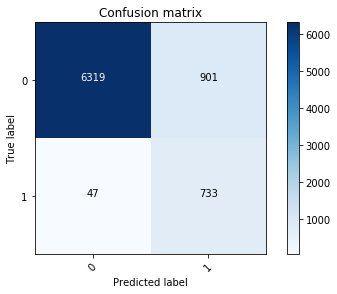

In [45]:
preds = m.predict(x_valid)
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
cm.diagonal()/cm.sum(axis=1)
print(classification_report(y_valid, preds))

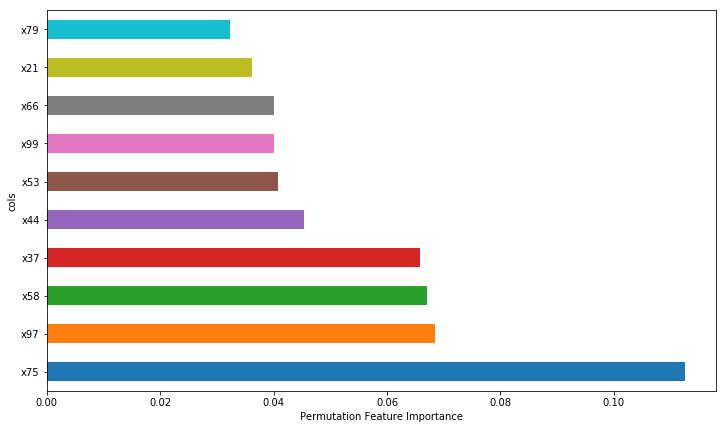

In [46]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, x_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

Reduction is now hit a wall and performance decreased below so the second reduction leading with 37 variables of interst. This will be something that will lead to more digging.

As I don't have a ton of time for this challenge I would also do this for the iterations that you will see below and make an excel sheet of the columns and rand commonalities between the tuning parameters. For this isolated task I will not go through all my methods

In [47]:
#Further Reduction
to_keep = fi_permutation[fi_permutation.imp > 0.005].cols; len(to_keep) 

33

In [48]:
x_valid = X_valid[to_keep].copy()
x_train = X_train[to_keep].copy();

x_train.shape, x_valid.shape

((32000, 33), (8000, 33))

In [49]:
m = RandomForestClassifier(n_jobs= -1, oob_score=True)
%time m.fit(x_train, y_train)
print("Training Acc:", round(m.score(x_train, y_train),5)),
print("Validation Acc:", round(m.score(x_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

CPU times: user 1.48 s, sys: 2.44 ms, total: 1.48 s
Wall time: 231 ms
Training Acc: 0.99197
Validation Acc: 0.87188
Out-of-Bag Acc: 0.85053


Accuracy Score Per Class
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      6366
           1       0.91      0.42      0.57      1634

   micro avg       0.87      0.87      0.87      8000
   macro avg       0.89      0.70      0.75      8000
weighted avg       0.88      0.87      0.85      8000



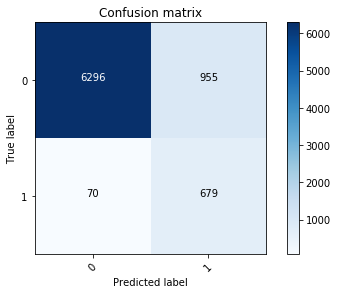

In [50]:
preds = m.predict(x_valid)
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y_valid, preds))

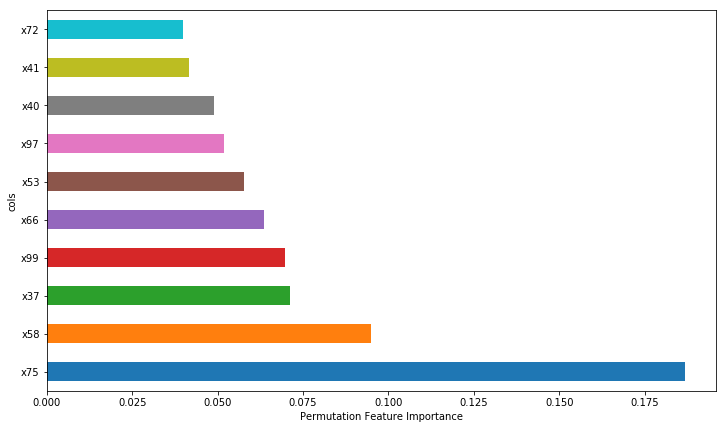

In [51]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, x_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

#### Hypertuning Baseline

In [52]:
second_reduction_columns = pd.read_csv('second_reduction_columns.csv', header=None)

In [53]:
second_reduction_columns.shape

(36, 1)

In [54]:
to_keep = second_reduction_columns.iloc[:,0]

In [55]:
X_valid = X_valid[to_keep].copy()
X_train = X_train[to_keep].copy();

X_train.shape, X_valid.shape

((32000, 36), (8000, 36))

In [56]:
def print_score(model):
    res = [roc_auc_score(m.predict(X_train), y_train), roc_auc_score(m.predict(X_valid), y_valid),
           round(m.score(X_train, y_train),5), round(m.score(X_valid, y_valid),5)]
    n = rfnnodes(m)
    h = np.median(rfmaxdepths(m))
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    print(f"Model using {n:,d} tree nodes with {h} median tree height")

Why create this print score this is to understand complexity of the model as well as having an easier to read method and only being two lines, but I will keep both methods in this so that a new user will be able to understand

In [57]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print_score(m)

CPU times: user 1.73 s, sys: 3.27 ms, total: 1.74 s
Wall time: 206 ms
Training Acc: 0.99188
Validation Acc: 0.87825
[0.9949081248755508, 0.9027747256931375, 0.99188, 0.87825]
Model using 48,346 tree nodes with 29.0 median tree height


In [58]:
#default is 10 trees NOTE THIS IS ON 20,000 not full dataset
#estimators is 10 because of the default so 20,0000 predictions 10 times
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

#These trees are going to show that the prediction of the 10 trees on the first observation, then mean, 
#then the validation prediction on validation set
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.]), 0.3, 1)

In [59]:
#Another example
preds[:,30], np.mean(preds[:,30]), y_valid[30]

(array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 0.1, 0)

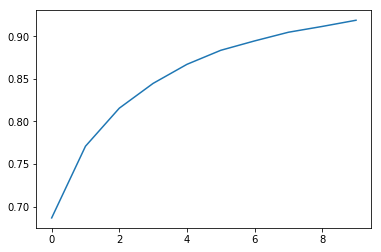

In [60]:
plt.plot([metrics.roc_auc_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(10)]);

In [61]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=20, oob_score=True)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))
print_score(m)

CPU times: user 3.65 s, sys: 2.43 ms, total: 3.65 s
Wall time: 460 ms
Training Acc: 0.99856
Validation Acc: 0.89188
Out-of-Bag Acc: 0.87453
[0.9991027191510943, 0.9272952768847847, 0.99856, 0.89188, 0.87453125]
Model using 96,632 tree nodes with 28.5 median tree height


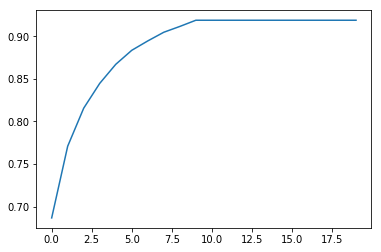

In [62]:
plt.plot([metrics.roc_auc_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(20)]);

We see the curve flatten at around 10 and we might get some improvement if we increase the number of trees, but this might be a marginal return, but looking at the oob score and that improvement is a solid improvement

In [63]:
for i, estim in enumerate((10,20,50,150,250)):
    m = RandomForestClassifier(n_jobs=-1, n_estimators= estim, oob_score=True)
    %time m.fit(X_train, y_train)
    
    print("estim=%.2f" % estim)
    print("Training Acc:", round(m.score(X_train, y_train), 5)),
    print("Validation Acc:", round(m.score(X_valid, y_valid),5)),
    print("Out of Bag Acc:", round(m.oob_score_, 5)),
    print_score(m)

CPU times: user 1.75 s, sys: 3.49 ms, total: 1.75 s
Wall time: 230 ms
estim=10.00
Training Acc: 0.99169
Validation Acc: 0.87525
Out of Bag Acc: 0.8505
[0.9947308442836151, 0.8971034482758621, 0.99169, 0.87525, 0.8505]
Model using 48,564 tree nodes with 31.5 median tree height
CPU times: user 3.84 s, sys: 1.74 ms, total: 3.84 s
Wall time: 603 ms
estim=20.00
Training Acc: 0.99859
Validation Acc: 0.89062
Out of Bag Acc: 0.87356
[0.9991221910112359, 0.9228491649463659, 0.99859, 0.89062, 0.8735625]
Model using 96,304 tree nodes with 28.0 median tree height
CPU times: user 9.92 s, sys: 4.59 ms, total: 9.93 s
Wall time: 1.18 s
estim=50.00
Training Acc: 0.99984
Validation Acc: 0.89875
Out of Bag Acc: 0.88956
[0.9999023132228821, 0.9340726988469806, 0.99984, 0.89875, 0.8895625]
Model using 242,420 tree nodes with 29.0 median tree height
CPU times: user 29.9 s, sys: 17.8 ms, total: 29.9 s
Wall time: 3 s
estim=150.00
Training Acc: 1.0
Validation Acc: 0.90088
Out of Bag Acc: 0.89597
[1.0, 0.936823

**Seeing a flattening of the OOB score** 

* For now staying at 50 estimators will be where this choice will be 

* Time to reduce the over fitting that we are seeing in our model

|Hyper Parameters: |
| --- | 
| n_estimators |
| min_samples_leaf |
| max_features |

**min_samples_leaf**

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

There are less decision rules for each leaf node; simpler models should generalize better
The predictions are made by averaging more rows in the leaf node, resulting in less volatility
Good sample_leaf sizes to try 1,3,5,10,25

**max_features** 

Less corelated trees are the better (Imagen if one column was very good at describing the relationship)
If every tree used the same one to start the split at then we would miss the interaction between variables
Variation of the tree at every single split point we take random samples of columns (This is column sampling)
We are not longer looking at every single option, but rather a subset of the columns
Options used in this feature are defalut = None, other good ideas are .50 or the 'sqrt' or log2

Are there more yes, but in my practice so far these are the features that lead to the most success in tunning for RDF

In [64]:
for i, Leaf in enumerate((1,3,5,10,25)):
    m = RandomForestClassifier(n_jobs=-1, n_estimators= 50, min_samples_leaf= Leaf, oob_score=True)
    %time m.fit(X_train, y_train)
    
    print("Leaf=%.2f" % Leaf)
    print("Training Acc:", round(m.score(X_train, y_train), 5)),
    print("Validation Acc:", round(m.score(X_valid, y_valid),5)),
    print("Out of Bag Acc:", round(m.oob_score_, 5))
    print_score(m)

CPU times: user 9.95 s, sys: 0 ns, total: 9.95 s
Wall time: 1.19 s
Leaf=1.00
Training Acc: 0.99988
Validation Acc: 0.89938
Out of Bag Acc: 0.89062
[0.9999218475245204, 0.9374881794819262, 0.99988, 0.89938, 0.890625]
Model using 242,330 tree nodes with 30.0 median tree height
CPU times: user 9.21 s, sys: 0 ns, total: 9.21 s
Wall time: 1.06 s
Leaf=3.00
Training Acc: 0.98959
Validation Acc: 0.89738
Out of Bag Acc: 0.89141
[0.993512975014235, 0.9322391723234287, 0.98959, 0.89738, 0.89140625]
Model using 182,314 tree nodes with 26.0 median tree height
CPU times: user 8.89 s, sys: 3.31 ms, total: 8.89 s
Wall time: 1.1 s
Leaf=5.00
Training Acc: 0.97181
Validation Acc: 0.89225
Out of Bag Acc: 0.89134
[0.9825364709866663, 0.9280563561727586, 0.97181, 0.89225, 0.89134375]
Model using 142,786 tree nodes with 24.0 median tree height
CPU times: user 8.18 s, sys: 0 ns, total: 8.18 s
Wall time: 948 ms
Leaf=10.00
Training Acc: 0.94044
Validation Acc: 0.88325
Out of Bag Acc: 0.88306
[0.9641065377765433

In [65]:
for i, feat in enumerate((.50,6,5,.80)):
    m = RandomForestClassifier(n_jobs=-1, n_estimators= 50, min_samples_leaf=3, max_features=feat, oob_score=True) 
    %time m.fit(X_train, y_train)
    
    print("feat=%.2f" % feat)
    print("Training Acc:", round(m.score(X_train, y_train), 5)),
    print("Validation Acc:", round(m.score(X_valid, y_valid),5)),
    print("Out of Bag Acc:", round(m.oob_score_, 5))
    print_score(m)

CPU times: user 28.1 s, sys: 22.5 ms, total: 28.1 s
Wall time: 2.72 s
feat=0.50
Training Acc: 0.98931
Validation Acc: 0.90288
Out of Bag Acc: 0.89697
[0.9932145726114068, 0.9170787961397628, 0.98931, 0.90288, 0.89696875]
Model using 149,084 tree nodes with 27.0 median tree height
CPU times: user 9.35 s, sys: 3.61 ms, total: 9.35 s
Wall time: 1.05 s
feat=6.00
Training Acc: 0.98916
Validation Acc: 0.897
Out of Bag Acc: 0.88991
[0.9931192094129929, 0.9305043903255853, 0.98916, 0.897, 0.88990625]
Model using 181,644 tree nodes with 26.0 median tree height
CPU times: user 7.78 s, sys: 7.64 ms, total: 7.79 s
Wall time: 821 ms
feat=5.00
Training Acc: 0.98981
Validation Acc: 0.8945
Out of Bag Acc: 0.88809
[0.9937097209894648, 0.9331238535226579, 0.98981, 0.8945, 0.88809375]
Model using 189,870 tree nodes with 26.0 median tree height
CPU times: user 44.2 s, sys: 0 ns, total: 44.2 s
Wall time: 4.22 s
feat=0.80
Training Acc: 0.99028
Validation Acc: 0.90412
Out of Bag Acc: 0.89828
[0.9938066373331

#### Coss Validate Results 

In [66]:
cvscore = cross_val_score(
    RandomForestClassifier(n_jobs=-1, n_estimators= 50, min_samples_leaf=3, max_features=5), 
    X_train, y_train, cv = 10, 
    scoring = 'roc_auc'
    )
chunk_valid = cvscore
err_cv = chunk_valid.mean()
print(f"{chunk_valid}, {err_cv:.2f} average cross-validation error")

[0.96050711 0.94968281 0.94958329 0.96461024 0.95933657 0.95477556
 0.95087419 0.95630758 0.95143772 0.9530542 ], 0.96 average cross-validation error


In [67]:
cvscore = cross_val_score(
    RandomForestClassifier(n_jobs=-1, n_estimators= 50, min_samples_leaf=3, max_features=0.5), 
    X_train, y_train, cv = 10, 
    scoring = 'roc_auc'
    )
chunk_valid = cvscore
err_cv = chunk_valid.mean()
print(f"{chunk_valid}, {err_cv:.2f} average cross-validation error")

[0.94800162 0.93726132 0.9386613  0.95408515 0.94904497 0.95068703
 0.94469887 0.94506787 0.93600725 0.9463355 ], 0.94 average cross-validation error


In [68]:
cvscore = cross_val_score(
    RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=5), 
    X_train, y_train, cv = 10, 
    scoring = 'roc_auc'
    )
chunk_valid = cvscore
err_cv = chunk_valid.mean()
print(f"{chunk_valid}, {err_cv:.2f} average cross-validation error")

[0.96426454 0.95876748 0.95772784 0.96650499 0.96355495 0.96124565
 0.95748937 0.96072613 0.9553699  0.96143816], 0.96 average cross-validation error


In [69]:
cvscore = cross_val_score(
    RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=0.5), 
    X_train, y_train, cv = 10, 
    scoring = 'roc_auc'
    )
chunk_valid = cvscore
err_cv = chunk_valid.mean()
print(f"{chunk_valid}, {err_cv:.2f} average cross-validation error")

[0.95110897 0.94335794 0.94234325 0.95812979 0.95625241 0.94959304
 0.94691185 0.94848196 0.94411586 0.94692068], 0.95 average cross-validation error


#### Evaluating Model After Tuning

In [70]:
m = RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=5, oob_score=True)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))
print_score(m)

CPU times: user 22.8 s, sys: 38.9 ms, total: 22.8 s
Wall time: 2.44 s
Training Acc: 0.99181
Validation Acc: 0.89388
Out-of-Bag Acc: 0.89197
[0.9948697969764707, 0.936038365923535, 0.99181, 0.89388, 0.89196875]
Model using 570,936 tree nodes with 26.0 median tree height


In [275]:
# from sklearn.externals import joblib
# joblib_file = "tmp/StateFarm35_RDF.pkl"
# # joblib.dump(m, joblib_file)

# #load
# joblib_file = "tmp/StateFarm35_RDF.pkl"
# joblib_model = joblib.load(joblib_file)

['tmp/StateFarm35_RDF.pkl']

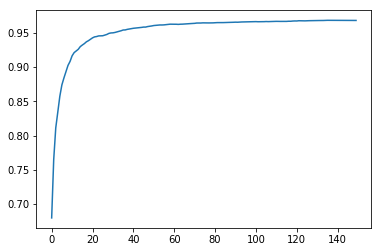

In [71]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.roc_auc_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(150)]);

This is showing the number of trees and the score by trees you see a slight increase all the way to 150 estimators. There might be some more trees to bring in, but for now I am happy with where we are at. Addtionally, we are using 5 features at random to allow the over fitting to decrease and we can see that this has helped with a increase in our validation score

Accuracy Score Per Class
[0.8832847  0.98879203]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6366
           1       0.99      0.49      0.65      1634

   micro avg       0.89      0.89      0.89      8000
   macro avg       0.94      0.74      0.79      8000
weighted avg       0.90      0.89      0.88      8000



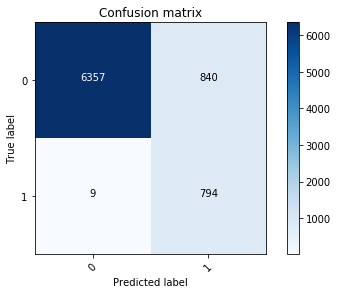

In [72]:
preds = m.predict(X_valid)
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y_valid, preds))

**Look Improvement** 

We are looking at really good increases in all metrics there is still a lot to be done with this, but making improvements slowly, but improvements are happening incrementally. 

- Things I am not using already are imblearn oversampler/manual oversampling/class weights 
    * In practice i have seen these not extrapolate as well as one would expect, but if time is remaining these will be looked into. 

#### Variable Importance/ Reduction/ Final Baseline Before Features

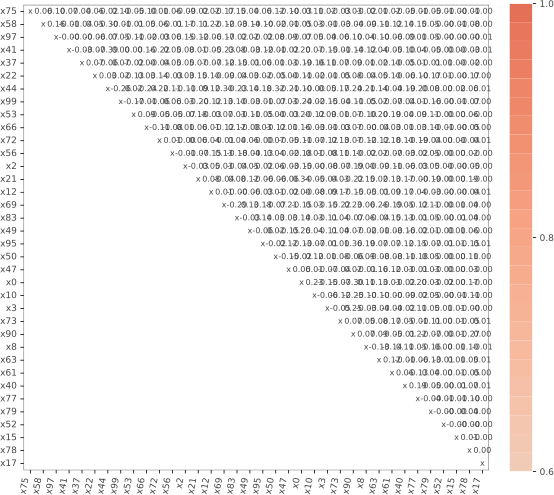

In [76]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(8,10))
#viz.save(f'{PATH}corrheatmap.svg')
viz

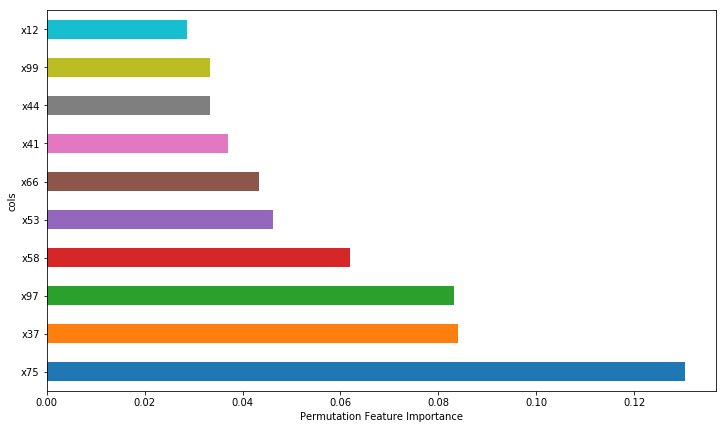

In [74]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, X_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

In [77]:
#Further Reduction
to_keep = fi_permutation[fi_permutation.imp > 0.005].cols; len(to_keep) 

31

In [78]:
x_valid = X_valid[to_keep].copy()
x_train = X_train[to_keep].copy()

In [80]:
def print_score(model):
    res = [roc_auc_score(m.predict(x_train), y_train), roc_auc_score(m.predict(x_valid), y_valid),
           round(m.score(x_train, y_train),5), round(m.score(x_valid, y_valid),5)]
    n = rfnnodes(m)
    h = np.median(rfmaxdepths(m))
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    print(f"Model using {n:,d} tree nodes with {h} median tree height")

In [81]:
m = RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=5, oob_score=True)
%time m.fit(x_train, y_train)
print("Training Acc:", round(m.score(x_train, y_train),5)),
print("Validation Acc:", round(m.score(x_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))
print_score(m)

CPU times: user 23.4 s, sys: 22.3 ms, total: 23.4 s
Wall time: 2.34 s
Training Acc: 0.99088
Validation Acc: 0.90012
Out-of-Bag Acc: 0.89391
[0.9943583600602806, 0.9374009119396017, 0.99088, 0.90012, 0.89390625]
Model using 562,900 tree nodes with 25.0 median tree height


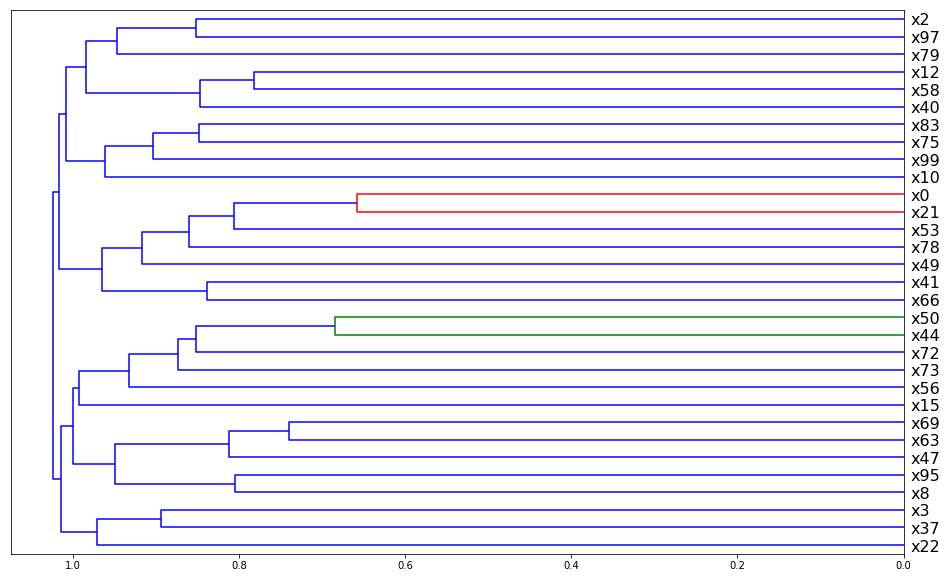

In [82]:
from scipy.cluster import hierarchy as hc
import scipy

#using the corelation spearman rank correlation
corr = np.round(scipy.stats.spearmanr(x_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=x_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [83]:
fi_permutation

cols       imp
0   x75  0.130314
1   x37  0.084104
2   x97  0.083179
3   x58  0.061922
4   x53  0.046211
5   x66  0.043438
6   x41  0.036969
7   x44  0.033272
8   x99  0.033272
9   x12  0.028651
10  x21  0.027726
11  x72  0.026802
12  x56  0.025878
13   x3  0.025878
14  x10  0.025878
15  x79  0.024030
16  x40  0.024030
17  x73  0.023105
18  x83  0.021257
19   x2  0.021257
20  x78  0.021257
21   x8  0.021257
22  x50  0.020333
23  x63  0.018484
24  x22  0.016636
25  x47  0.014787
26  x69  0.012015
27   x0  0.011091
28  x49  0.010166
29  x95  0.008318
30  x15  0.007394
31  x90  0.004621
32  x17  0.004621
33  x77  0.001848
34  x61  0.000000
35  x52  0.000000

Everything seems to be fine, but ``x50 & x44`` with ``x0 & x21`` with some corelation we will drop the least of the important variables when testing against OOB and the variable importance

In [84]:
def get_oob(df):
    m = RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf= 3, max_features=5, oob_score=True)
    x = x_train
    m.fit(x, y_train)
    return m.oob_score_

In [85]:
get_oob(x_train)

0.8940625

In [86]:
x_train.columns

Index(['x75', 'x37', 'x97', 'x58', 'x53', 'x66', 'x41', 'x44', 'x99', 'x12',
       'x21', 'x72', 'x56', 'x3', 'x10', 'x79', 'x40', 'x73', 'x83', 'x2',
       'x78', 'x8', 'x50', 'x63', 'x22', 'x47', 'x69', 'x0', 'x49', 'x95',
       'x15'],
      dtype='object')

In [87]:
for c in (['x44', 'x0', 'x21', 'x50']):
    print(c, get_oob(x_train.drop(c, axis= 1)))

x44 0.8939375
x0 0.89425
x21 0.89540625
x50 0.8940625


In [88]:
to_drop = ['x0', 'x50']
get_oob(x_train.drop(to_drop, axis=1))

0.89340625

In [89]:
x_valid.drop(to_drop, axis=1, inplace=True)
x_train.drop(to_drop, axis=1, inplace=True)

In [90]:
x_valid.shape

(8000, 29)

In [91]:
x_train.shape

(32000, 29)

In [92]:
m = RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=5, oob_score=True)
%time m.fit(x_train, y_train)
print("Training Acc:", round(m.score(x_train, y_train),5)),
print("Validation Acc:", round(m.score(x_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))
print_score(m)

CPU times: user 23.5 s, sys: 6.94 ms, total: 23.5 s
Wall time: 2.35 s
Training Acc: 0.98962
Validation Acc: 0.89925
Out-of-Bag Acc: 0.89434
[0.9934686925257038, 0.9333755049610892, 0.98962, 0.89925, 0.89434375]
Model using 562,430 tree nodes with 25.5 median tree height


In [94]:
# from sklearn.externals import joblib
# joblib_file = "tmp/StateFarm35_RDF.pkl"
# joblib.dump(m, joblib_file)

['tmp/StateFarm35_RDF.pkl']

Accuracy Score Per Class
[0.88979248 0.97695853]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6366
           1       0.98      0.52      0.68      1634

   micro avg       0.90      0.90      0.90      8000
   macro avg       0.93      0.76      0.81      8000
weighted avg       0.91      0.90      0.89      8000



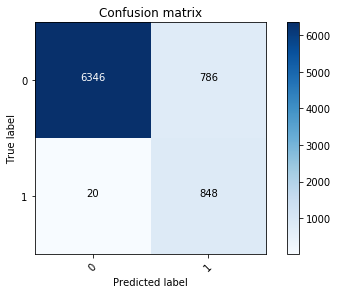

In [93]:
preds = m.predict(x_valid)
cm = confusion_matrix(preds, y_valid)
plot_confusion_matrix(cm, np.unique(y_valid))
print('Accuracy Score Per Class')
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y_valid, preds))

In [269]:
#ROC Curve Per Class
probs = m.predict_proba(x_valid)

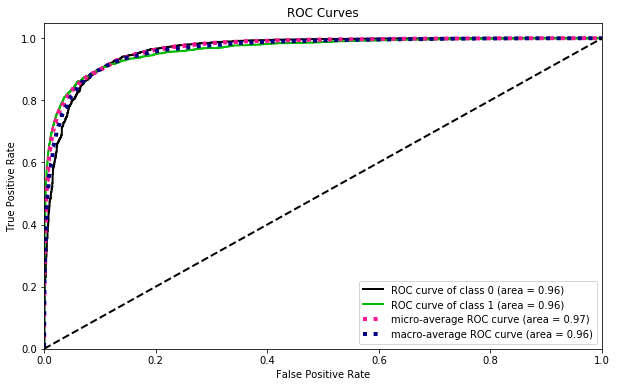

In [270]:
skplt.metrics.plot_roc(y_valid, probs, figsize=(10,6));plt.show()

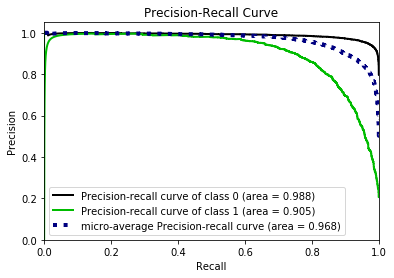

In [271]:
skplt.metrics.plot_precision_recall(y_valid, probs);plt.show()

In [ ]:
keep_columns = x_train.columns

columns_keep = pd.DataFrame(keep_columns)

to_keep = columns_keep.iloc[:,0]

In [95]:
to_keep.to_csv('third_reduction_columns.csv', index=False)

In [99]:
third_reduction_columns = pd.read_csv('third_reduction_columns.csv', header=None);
to_keep = third_reduction_columns.iloc[:,0]

In [100]:
X_valid = X_valid[to_keep].copy()
X_train = X_train[to_keep].copy();

In [101]:
X_train.shape, X_valid.shape

((32000, 29), (8000, 29))

#### Feature Engineering

Slight deviation in the important variables. 

- x75 is leading the back and some investigation will need to be done on this variable. 

- x41 with the std of 100+ with out scaling is also in the top 10 variables leading this model type. 

    - This is the dollar amount variable, this is a state farm problem it's probably okay to assume this is some type of claim or insurance data set. Feature to create (neg / pos) (percentile loss and gain)

- EDA on the top 10 variables will most likely need to be done and features if possible will be created with those. 

    - Note features of DOW there will be weekday or weekend (x35)
    - Month Season type (Winter, Spring, Summer, Fall) 
    - Cars (Luxury or Cheap) (USA or Foriegn) (x34)

**Top 10 Importance**

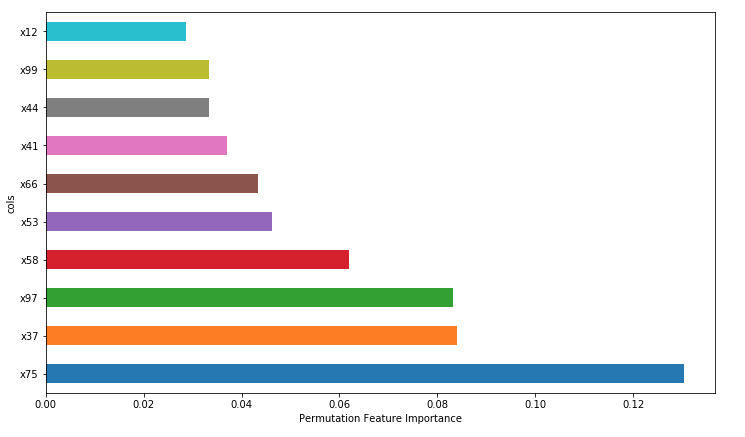

In [568]:
df_raw.to_pickle(f'tmp/df_raw.csv')

In [590]:
df = pd.read_pickle(f'tmp/df_raw.csv');df.shape

(40000, 101)

In [591]:
display_all(df.head())

x0         x1         x2         x3         x4         x5        x6  \
0  10.142889 -15.675620   3.583176 -22.397489  27.221894 -34.110924 -0.072829   
1 -52.214630   5.847135 -10.902843 -14.132351  20.588574  36.107322  0.115023   
2  67.718500   2.064334  12.394186 -18.667102  47.465504 -50.373658  0.253707   
3 -28.003111   8.565128  -8.592092   5.918960  -3.224154  78.315783 -0.879845   
4  80.703016  30.736353 -30.101857 -21.201140 -91.946233 -47.469246 -0.646831   

         x7        x8        x9       x10       x11        x12       x13  \
0 -0.544444  0.997601 -2.691778 -0.923879  8.109456  27.872550 -3.420582   
1  0.276093 -0.699168 -0.972708  1.287131  5.717183  -3.761334 -5.074973   
2  1.068968  2.939713  2.691218  3.058585  7.537863 -19.130709 -0.906646   
3  1.176889 -2.414752  0.589646 -0.906179  0.087087  25.075633 -0.834239   
4 -0.578398  0.980849 -1.426112  0.363235  5.836213  29.396618 -2.591986   

        x14       x15        x16       x17        x18        x19        x20  \
0  1.511710  6.673493  -4.323289 -1.538177  12.853393 -23.583975 -26.410490   
1 -1.296964 -2.366536 -19.532219 -0.651274  -0.758730  -5.580162  47.151801   
2 -2.794020 -3.978507  14.237849  1.373681   9.635405 -16.183555  16.922392   
3 -0.027757  3.708857 -12.314642  2.700113   7.216934  74.438816  61.764811   
4 -1.555760  4.963425   3.703779 -0.010266  -2.837060  48.985375  23.961394   

        x21        x22        x23        x24        x25       x26        x27  \
0  2.328126 -28.226474  -4.131820   0.268103  -5.661808 -2.782330  30.276359   
1  2.053410  -4.348193 -17.632414  -3.963233 -27.385429  1.991331  25.995571   
2  1.663092  -9.758591 -13.040577 -13.865584   4.965384  0.940166  16.305724   
3 -1.605895 -15.125777   5.556041   4.593257 -16.996278 -3.875344   5.064833   
4  4.685315  21.758491   1.466513  -3.417453  45.498835  4.821398  35.093986   

        x28       x29       x30       x31       x32        x33     x34  x35  \
0 -0.944980  0.277266 -2.233740  0.515763  0.004137 -27.321975     bmw  wed   
1 -1.390032 -0.791795  2.537591 -1.138456 -1.202222  48.491336  nissan  thu   
2  0.112402 -1.199571  1.286813  0.277410  0.682253  -6.741030   honda  wed   
3 -1.296087  1.630619 -4.694258 -0.722119 -1.689241 -20.987787  toyota  thu   
4  4.404143  1.387974 -4.123902  2.092002 -0.005312 -65.261291     bmw  thu   

        x36       x37       x38       x39        x40     x41         x42  \
0  5.613605 -8.771422  1.012030 -2.122949   0.500782  -54.10  -60.377200   
1 -2.132043  1.288928 -1.622637 -0.919865   9.054563 -229.32 -280.208298   
2  3.206642 -8.065741  0.838277 -0.465169   1.225612  243.68 -119.470071   
3 -3.589886  4.368415 -1.045650  1.613660  -4.185118  126.15  129.270157   
4  9.953264  4.303842  0.632836  1.657977  10.945454  877.39 -319.428734   

         x43         x44   x45       x46        x47       x48        x49  \
0 -14.343129  -38.244485  0.00 -8.346880   0.300698 -3.560418 -29.858649   
1 -46.045485   -7.783574  0.01 -2.248960  15.868349 -2.320347  29.611460   
2  25.462689   56.571522  0.01 -2.161725   7.287187 -2.414766 -19.325576   
3  13.413693  115.018748  0.02  4.206076 -40.254305  0.049048  28.853906   
4   9.194313  -89.678180  0.02  1.189501   4.036919  0.296720 -34.969908   

        x50       x51       x52        x53        x54       x55        x56  \
0 -0.004122 -1.034268  2.280323  -9.220175  -0.672959 -1.352266  19.547038   
1  0.035378 -9.960903  0.662594 -40.051587  -7.467978  0.150334  13.798547   
2  0.865352 -8.971459  0.182888  25.383424  -4.359127 -0.198638   3.231385   
3  0.263934  7.778529  3.748663  -1.119398 -13.652775  0.339680  -8.812638   
4 -0.490233 -2.936929  1.080471  15.078833   6.662614  0.411686  -0.192318   

         x57        x58       x59       x60        x61       x62       x63  \
0  -6.706483 -16.123533 -5.271198  0.099280  -4.905632  0.557732 -3.858105   
1 -19.627385 -28.046366 -8.330669  0.014509  -3.445528  0.109443 -4.855778   
2 -34.887447 -19.6

In [592]:
third_reduction_columns = pd.read_csv('third_reduction_columns.csv', header=None);
to_keep = third_reduction_columns.iloc[:,0]

len(to_keep)

to_keep_y = to_keep.copy()
to_keep_y.loc[29] = 'y'

In [593]:
#to add cat features back to allow for feature engin
to_keep_cats = to_keep_y.copy()

In [594]:
to_drop = ['x35','x34','x93','x68']

In [595]:
to_keep_cats.loc[30]='x35'
to_keep_cats.loc[31]='x34'
to_keep_cats.loc[32]='x93'
to_keep_cats.loc[33]='x68'

**Columns Being Used**

- None of the categorical variables were picked up when they were label encoded, but I am going to see if bringing in features on the categorical variables. I am also going to bring them in and checking if the order was properly assigned. 

```python
['x75', 'x37', 'x97', 'x58', 'x53', 'x66', 'x41', 'x44', 'x99', 'x12',
 'x21', 'x72', 'x56', 'x3', 'x10', 'x79', 'x40', 'x73', 'x83', 'x2',
 'x78', 'x8', 'x63', 'x22', 'x47', 'x69', 'x49', 'x95', 'x15']
```

**x75** (Not Enough Time To Look Into)

What is is about this variable that is leading to be the strongest predictor. 

In [596]:
display_all(df.head())

x0         x1         x2         x3         x4         x5        x6  \
0  10.142889 -15.675620   3.583176 -22.397489  27.221894 -34.110924 -0.072829   
1 -52.214630   5.847135 -10.902843 -14.132351  20.588574  36.107322  0.115023   
2  67.718500   2.064334  12.394186 -18.667102  47.465504 -50.373658  0.253707   
3 -28.003111   8.565128  -8.592092   5.918960  -3.224154  78.315783 -0.879845   
4  80.703016  30.736353 -30.101857 -21.201140 -91.946233 -47.469246 -0.646831   

         x7        x8        x9       x10       x11        x12       x13  \
0 -0.544444  0.997601 -2.691778 -0.923879  8.109456  27.872550 -3.420582   
1  0.276093 -0.699168 -0.972708  1.287131  5.717183  -3.761334 -5.074973   
2  1.068968  2.939713  2.691218  3.058585  7.537863 -19.130709 -0.906646   
3  1.176889 -2.414752  0.589646 -0.906179  0.087087  25.075633 -0.834239   
4 -0.578398  0.980849 -1.426112  0.363235  5.836213  29.396618 -2.591986   

        x14       x15        x16       x17        x18        x19        x20  \
0  1.511710  6.673493  -4.323289 -1.538177  12.853393 -23.583975 -26.410490   
1 -1.296964 -2.366536 -19.532219 -0.651274  -0.758730  -5.580162  47.151801   
2 -2.794020 -3.978507  14.237849  1.373681   9.635405 -16.183555  16.922392   
3 -0.027757  3.708857 -12.314642  2.700113   7.216934  74.438816  61.764811   
4 -1.555760  4.963425   3.703779 -0.010266  -2.837060  48.985375  23.961394   

        x21        x22        x23        x24        x25       x26        x27  \
0  2.328126 -28.226474  -4.131820   0.268103  -5.661808 -2.782330  30.276359   
1  2.053410  -4.348193 -17.632414  -3.963233 -27.385429  1.991331  25.995571   
2  1.663092  -9.758591 -13.040577 -13.865584   4.965384  0.940166  16.305724   
3 -1.605895 -15.125777   5.556041   4.593257 -16.996278 -3.875344   5.064833   
4  4.685315  21.758491   1.466513  -3.417453  45.498835  4.821398  35.093986   

        x28       x29       x30       x31       x32        x33     x34  x35  \
0 -0.944980  0.277266 -2.233740  0.515763  0.004137 -27.321975     bmw  wed   
1 -1.390032 -0.791795  2.537591 -1.138456 -1.202222  48.491336  nissan  thu   
2  0.112402 -1.199571  1.286813  0.277410  0.682253  -6.741030   honda  wed   
3 -1.296087  1.630619 -4.694258 -0.722119 -1.689241 -20.987787  toyota  thu   
4  4.404143  1.387974 -4.123902  2.092002 -0.005312 -65.261291     bmw  thu   

        x36       x37       x38       x39        x40     x41         x42  \
0  5.613605 -8.771422  1.012030 -2.122949   0.500782  -54.10  -60.377200   
1 -2.132043  1.288928 -1.622637 -0.919865   9.054563 -229.32 -280.208298   
2  3.206642 -8.065741  0.838277 -0.465169   1.225612  243.68 -119.470071   
3 -3.589886  4.368415 -1.045650  1.613660  -4.185118  126.15  129.270157   
4  9.953264  4.303842  0.632836  1.657977  10.945454  877.39 -319.428734   

         x43         x44   x45       x46        x47       x48        x49  \
0 -14.343129  -38.244485  0.00 -8.346880   0.300698 -3.560418 -29.858649   
1 -46.045485   -7.783574  0.01 -2.248960  15.868349 -2.320347  29.611460   
2  25.462689   56.571522  0.01 -2.161725   7.287187 -2.414766 -19.325576   
3  13.413693  115.018748  0.02  4.206076 -40.254305  0.049048  28.853906   
4   9.194313  -89.678180  0.02  1.189501   4.036919  0.296720 -34.969908   

        x50       x51       x52        x53        x54       x55        x56  \
0 -0.004122 -1.034268  2.280323  -9.220175  -0.672959 -1.352266  19.547038   
1  0.035378 -9.960903  0.662594 -40.051587  -7.467978  0.150334  13.798547   
2  0.865352 -8.971459  0.182888  25.383424  -4.359127 -0.198638   3.231385   
3  0.263934  7.778529  3.748663  -1.119398 -13.652775  0.339680  -8.812638   
4 -0.490233 -2.936929  1.080471  15.078833   6.662614  0.411686  -0.192318   

         x57        x58       x59       x60        x61       x62       x63  \
0  -6.706483 -16.123533 -5.271198  0.099280  -4.905632  0.557732 -3.858105   
1 -19.627385 -28.046366 -8.330669  0.014509  -3.445528  0.109443 -4.855778   
2 -34.887447 -19.6

In [597]:
train_cats(df)

In [598]:
df = df[to_keep_cats].copy()

In [599]:
display_all(df.head())

x75       x37        x97        x58        x53        x66     x41  \
0 -14.699572 -8.771422 -14.291524 -16.123533  -9.220175 -44.973467  -54.10   
1  66.730645  1.288928  10.037003 -28.046366 -40.051587 -93.785215 -229.32   
2  -5.291719 -8.065741   7.643215 -19.617867  25.383424  21.554429  243.68   
3   5.417055  4.368415  -9.180674 -18.611055  -1.119398  43.310615  126.15   
4 -16.692813  4.303842 -12.262072 -26.655796  15.078833  -2.179154  877.39   

          x44        x99        x12       x21        x72        x56  \
0  -38.244485  18.110170  27.872550  2.328126 -23.493130  19.547038   
1   -7.783574  -3.486898  -3.761334  2.053410  11.269393  13.798547   
2   56.571522 -79.358236 -19.130709  1.663092  -3.910715   3.231385   
3  115.018748  14.475681  25.075633 -1.605895  16.240854  -8.812638   
4  -89.678180 -19.003881  29.396618  4.685315  -4.428734  -0.192318   

          x3       x10        x79        x40        x73        x83         x2  \
0 -22.397489 -0.923879 -15.406388   0.500782 -14.127448  16.018401   3.583176   
1 -14.132351  1.287131 -24.134625   9.054563   1.432276  37.616056 -10.902843   
2 -18.667102  3.058585   4.451489   1.225612   2.961145  39.526904  12.394186   
3   5.918960 -0.906179   6.482230  -4.185118  14.623078  -0.781164  -8.592092   
4 -21.201140  0.363235 -17.041233  10.945454 -10.618561  -4.378634 -30.101857   

        x78        x8       x63        x22        x47        x69        x49  \
0  7.077637  0.997601 -3.858105 -28.226474   0.300698  20.093447 -29.858649   
1  5.797127 -0.699168 -4.855778  -4.348193  15.868349   9.645175  29.611460   
2  3.589234  2.939713  0.956671  -9.758591   7.287187 -21.659163 -19.325576   
3  0.592219 -2.414752 -0.363571 -15.125777 -40.254305  -0.785643  28.853906   
4 -0.765925  0.980849  3.237440  21.758491   4.036919 -20.562510 -34.969908   

         x95       x15  y  x35     x34     x93  x68  
0   0.454074  6.673493  0  wed     bmw  euorpe  jun  
1  31.921833 -2.366536  0  thu  nissan    asia  jul  
2   9.401490 -3.978507  0  wed   honda    asia  jul  
3 -20.312810  3.708857  0  thu  toyota    asia  may  
4 -29.334324  4.963425  0  thu     bmw    asia  jul

In [600]:
df.x35.unique()

[wed, thu, fri, tue, mon, NaN]
Categories (5, object): [fri < mon < thu < tue < wed]

In [601]:
#Middle 80
def serverity(x):
    if  -2383 < x <= 846:
        return 'normal'
    else:
        return 'rare'

In [602]:
def car_type(x):
    if (x == 'bmw') | (x == 'mercades') | (x == 'tesla') | (x == 'chrystler'):
        return 'luxury'
    else:
        return 'economy'

In [603]:
def usa_made(x):
    if (x == 'ford') | (x == 'nissan')| (x == 'tesla') | (x == 'chevrolet') | (x == 'chrystler'):
        return 'usa'
    else:
        return 'outside_us'

In [604]:
def season(x):
    if (x == 'mar') | (x == 'apr')| (x == 'may'):
        return 'spring'
    elif (x == 'jun') | (x == 'jul')| (x == 'aug'):
        return 'summer'
    elif (x == 'sep') | (x == 'oct')| (x == 'nov'):
        return 'Adult'
    else:
        return 'winter'

In [605]:
df['x41_cat'] = df.loc[:,'x41'].apply(serverity)
df['x34_cat_type'] = df.loc[:,'x34'].apply(car_type)
df['x34_cat_made'] = df.loc[:,'x34'].apply(usa_made)
df['x68_cat'] = df.loc[:,'x68'].apply(season)

In [606]:
from sklearn.utils import class_weight
#n_samples / (n_classes * np.bincount(y))
keys = np.unique(df.y)
weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(df.y), y=df.y)
cw = dict(zip(keys, weights))
cw

{0: 0.6259193189997809, 1: 2.4853982850751835}

In [608]:
display_all(df.head())

x75       x37        x97        x58        x53        x66     x41  \
0 -14.699572 -8.771422 -14.291524 -16.123533  -9.220175 -44.973467  -54.10   
1  66.730645  1.288928  10.037003 -28.046366 -40.051587 -93.785215 -229.32   
2  -5.291719 -8.065741   7.643215 -19.617867  25.383424  21.554429  243.68   
3   5.417055  4.368415  -9.180674 -18.611055  -1.119398  43.310615  126.15   
4 -16.692813  4.303842 -12.262072 -26.655796  15.078833  -2.179154  877.39   

          x44        x99        x12       x21        x72        x56  \
0  -38.244485  18.110170  27.872550  2.328126 -23.493130  19.547038   
1   -7.783574  -3.486898  -3.761334  2.053410  11.269393  13.798547   
2   56.571522 -79.358236 -19.130709  1.663092  -3.910715   3.231385   
3  115.018748  14.475681  25.075633 -1.605895  16.240854  -8.812638   
4  -89.678180 -19.003881  29.396618  4.685315  -4.428734  -0.192318   

          x3       x10        x79        x40        x73        x83         x2  \
0 -22.397489 -0.923879 -15.406388   0.500782 -14.127448  16.018401   3.583176   
1 -14.132351  1.287131 -24.134625   9.054563   1.432276  37.616056 -10.902843   
2 -18.667102  3.058585   4.451489   1.225612   2.961145  39.526904  12.394186   
3   5.918960 -0.906179   6.482230  -4.185118  14.623078  -0.781164  -8.592092   
4 -21.201140  0.363235 -17.041233  10.945454 -10.618561  -4.378634 -30.101857   

        x78        x8       x63        x22        x47        x69        x49  \
0  7.077637  0.997601 -3.858105 -28.226474   0.300698  20.093447 -29.858649   
1  5.797127 -0.699168 -4.855778  -4.348193  15.868349   9.645175  29.611460   
2  3.589234  2.939713  0.956671  -9.758591   7.287187 -21.659163 -19.325576   
3  0.592219 -2.414752 -0.363571 -15.125777 -40.254305  -0.785643  28.853906   
4 -0.765925  0.980849  3.237440  21.758491   4.036919 -20.562510 -34.969908   

         x95       x15  y  x35     x34     x93  x68 x41_cat x34_cat_type  \
0   0.454074  6.673493  0  wed     bmw  euorpe  jun  normal       luxury   
1  31.921833 -2.366536  0  thu  nissan    asia  jul  normal      economy   
2   9.401490 -3.978507  0  wed   honda    asia  jul  normal      economy   
3 -20.312810  3.708857  0  thu  toyota    asia  may  normal      economy   
4 -29.334324  4.963425  0  thu     bmw    asia  jul    rare       luxury   

  x34_cat_made x68_cat  
0   outside_us  summer  
1          usa  summer  
2   outside_us  summer  
3   outside_us  spring  
4   outside_us  summer

#### EDA 

Remember the large std for some of the variables let's take a look at them 2 of the 3 of them made it through prunning

In [569]:
train_cats(df)

In [549]:
#This split_data (prepares data for being split and scaling, imputation)
df_trn_anom, y_trn_anom, nas_anom = split_data(df, 'y')

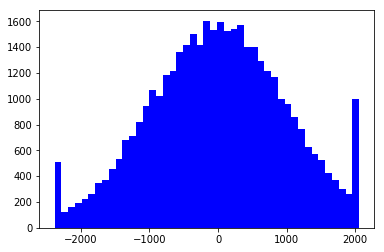

In [550]:
upper, lower = np.percentile(df_trn_anom.x41, [1,98]) # find middle 98% 
clipped = np.clip(df_raw.x41, upper, lower)
fig,ax = plt.subplots()
ax.hist(clipped, bins=45, color='blue')
plt.show()

In [551]:
#Non-Scaled
upper, lower

(-2383.421, 2057.0611999999996)

In [552]:
pd.value_counts((df_raw.x41 > 1641) | (df_raw.x41 < -1638) )

False    35994
True      4006
Name: x41, dtype: int64

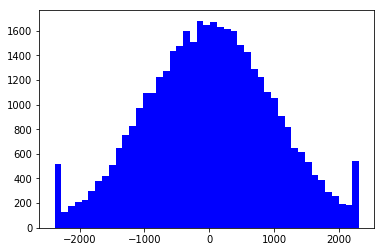

In [553]:
upper, lower = np.percentile(df_trn_anom.x41, [1,99]) # find middle 98% 
clipped = np.clip(df_trn_anom.x41, upper, lower)
fig,ax = plt.subplots()
ax.hist(clipped, bins=45, color='blue')
plt.show()

In [554]:
#Scaled
upper, lower

(-2383.421, 2308.0233000000007)

In [555]:
df_dis, y_trn_dis, nas_dis = split_data(df, 'y')

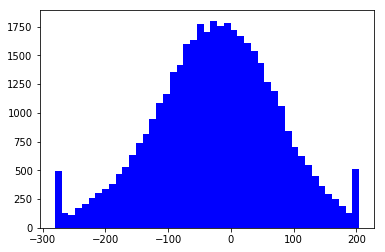

In [556]:
upper, lower = np.percentile(df_dis.x44, [1,99]) # find middle 98%
clipped = np.clip(df_dis.x44, upper, lower)
fig,ax = plt.subplots()
ax.hist(clipped, bins=45, color='blue')
plt.show()

In [557]:
upper, lower

(-280.7434463781066, 204.36275868769425)

In [558]:
pd.value_counts((df_dis.x41 > 1641) | (df_dis.x41 < -1638) |(df_dis.x44 > 204) | (df_dis.x44 < -208))

False    34481
True      5519
dtype: int64

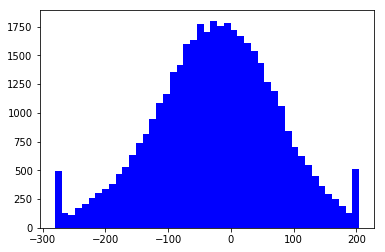

In [559]:
upper, lower = np.percentile(df_dis.x44, [1,99]) # find middle 98%
clipped = np.clip(df_dis.x44, upper, lower)
fig,ax = plt.subplots()
ax.hist(clipped, bins=45, color='blue')
plt.show()

In [560]:
upper,lower

(-280.7434463781066, 204.36275868769425)

In [ ]:
upper,lower

In [562]:
pd.value_counts((df_dis.x41 > 1641) | (df_dis.x41 < -1638) |(df_dis.x44 > 204) | (df_dis.x44 < -208))

False    34481
True      5519
dtype: int64

**Heavy Tailed Normal distrubted Data Points**

``x41 , x44, x90`` Each of these have std of over 100 in the measurement that they are measuring. This seems excessive as the next highest std ~40, but with not know what this is and what it is measuring removing 11K observations might not be the proper approach, but something that might be worth looking into. ``x90`` didn't make it this far and will be thrown away for now. 

- I am not sure right now how to attack this, but having notes to remind myself where I might want to go is something good to have. I have already scaled the data in the baseline model. Possibily moving towards a box cox method of transformation 

In [613]:
#Intersted in the distrubtions of my training and test set 
df = df_raw[to_keep_y].copy()
df_test = df_test[to_keep].copy()
train_cats(df)
apply_cats(df_test, df)
#NOTE not scaling so this makes intutive sense
trn_df, _, nas = split_data(df, 'y')
trn_df = trn_df[to_keep]
test_df, _, nas = split_data(df_test, na_dict=nas)
trn_df = trn_df[to_keep]
test_df = test_df[to_keep]

(40000, 30)

In [645]:
trn_df.shape, test_df.shape

((40000, 29), (10000, 29))

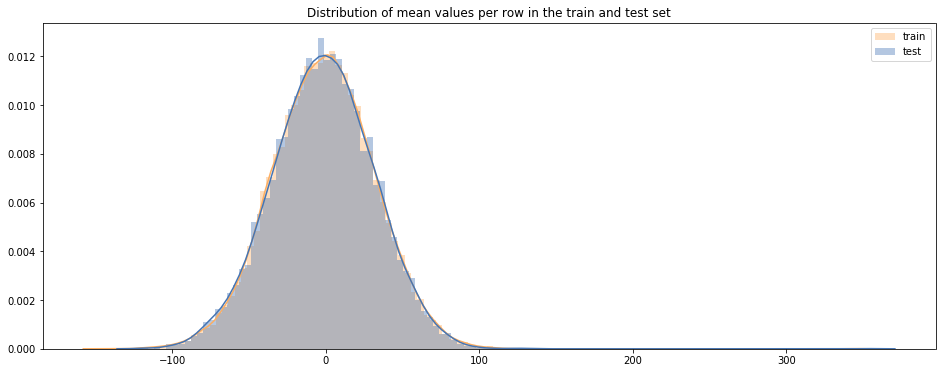

In [646]:
#Now that we know there are some odd distrubtions let's look and see if our test and train are similar
plt.figure(figsize=(16,6))
features = trn_df.columns.values[0:37]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(trn_df[features].mean(axis=1),color="#fdae61", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="#4575b4", kde=True,bins=120, label='test')
plt.legend()
plt.show()

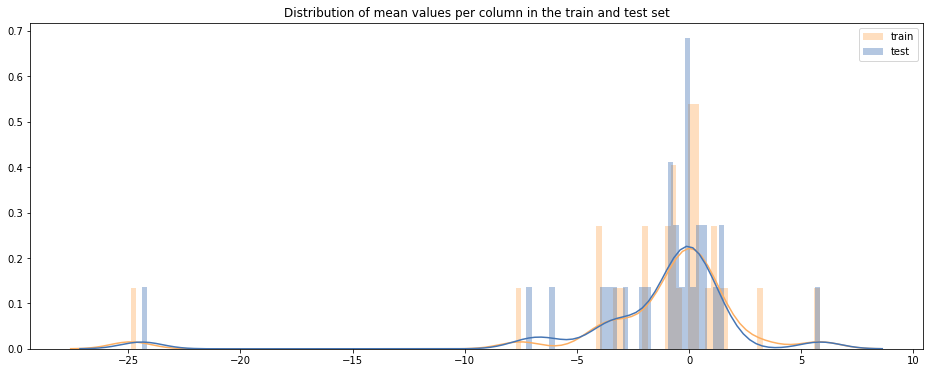

In [647]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(trn_df[features].mean(axis=0),color="#fdae61",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="#4575b4", kde=True,bins=120, label='test')
plt.legend()
plt.show()

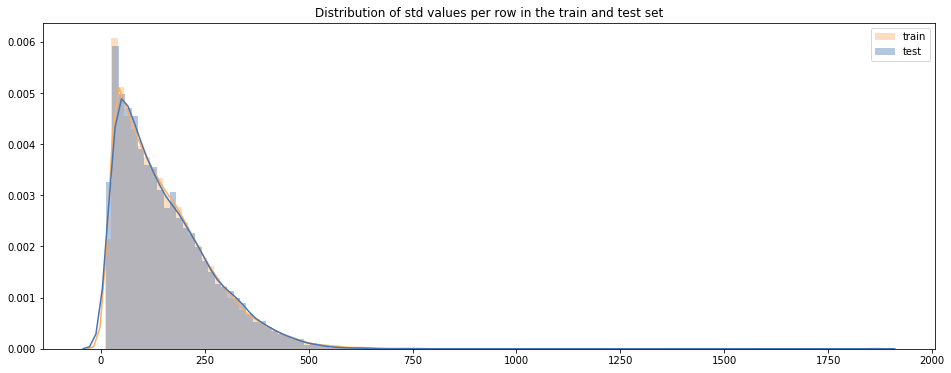

In [648]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(trn_df[features].std(axis=1),color="#fdae61", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="#4575b4", kde=True,bins=120, label='test')
plt.legend();plt.show()

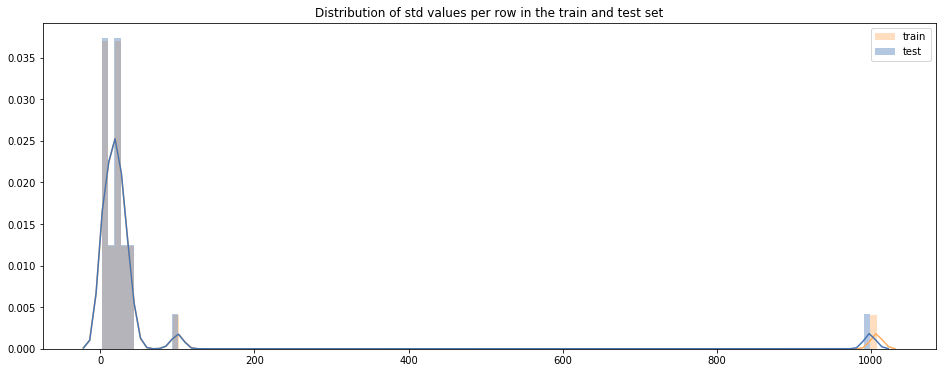

In [653]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(trn_df[features].std(axis=0),color="#fdae61", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="#4575b4", kde=True,bins=120, label='test')
plt.legend();plt.show()

Everything looks to be in order we do see a slight skew from the training and test, but nothing that I am overly worried about at this time. We also know that the odd distrubtions for columns are due to the fact nothing is scaled. One thing that does catch my eye is that the test set has some larger values, which could lead to a problem.

**This is all I am comfortable doing with the test set**

- Now that we know that the distrubtions seem to be ~ the same for std/mean for column and row, I would like to look at this for the target variable for training set. 

In [672]:
df = df_raw[to_keep_y].copy(); df.shape

(40000, 30)

In [673]:
train_cats(df)
df_trn, _, nas = split_data(df, _)

In [675]:
df_trn = df_raw[to_keep_y].copy()

In [681]:
#since I don't have a test set with labels i will look at the distrubtions with in my training
features = df_trn.columns.values
df_trn0 = df_trn.loc[df_trn.y==0, features]
df_trn1 = df_trn.loc[df_trn.y==1, features]

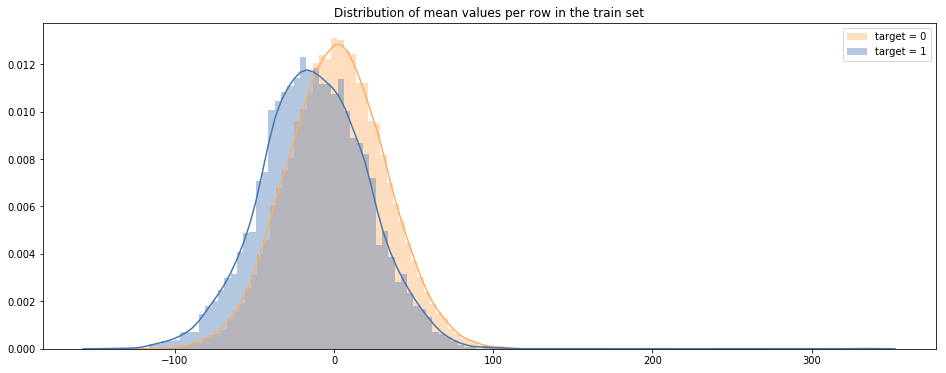

In [689]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(df_trn0[features].mean(axis=1),color="#fdae61", kde=True,bins=120, label='target = 0')
sns.distplot(df_trn1[features].mean(axis=1),color="#4575b4", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

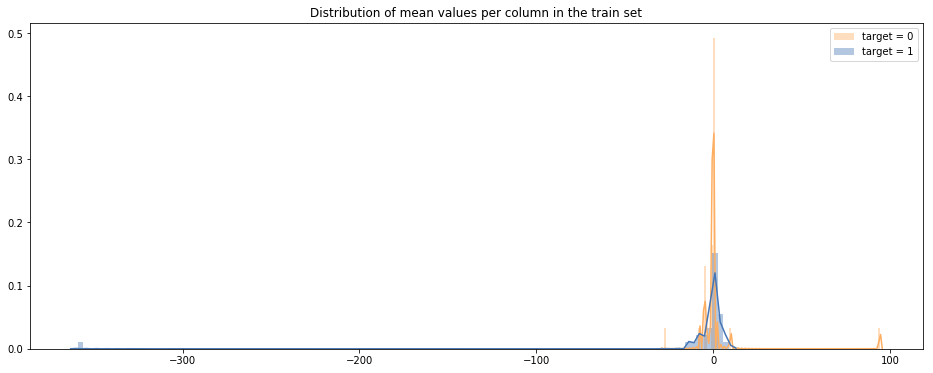

In [690]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(df_trn0[features].mean(axis=0),color="#fdae61", kde=True,bins=120, label='target = 0')
sns.distplot(df_trn1[features].mean(axis=0),color="#4575b4", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

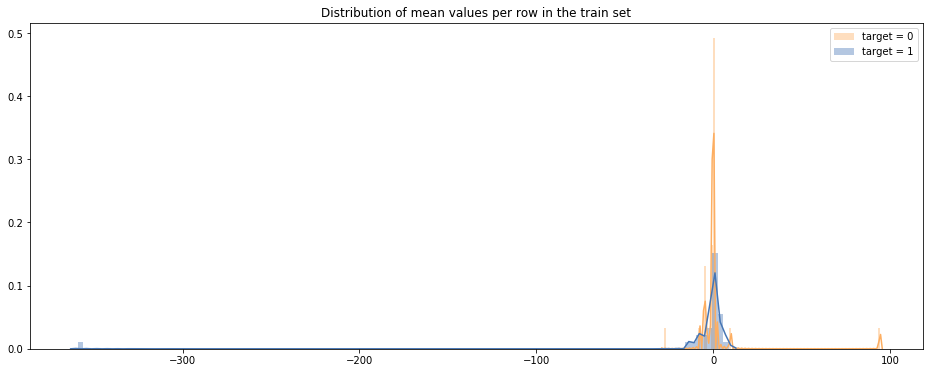

In [691]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(df_trn0[features].mean(axis=0),color="#fdae61", kde=True,bins=120, label='target = 0')
sns.distplot(df_trn1[features].mean(axis=0),color="#4575b4", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

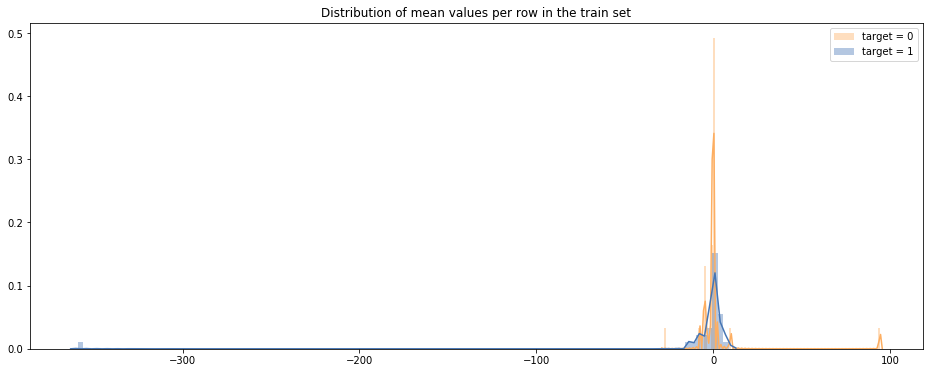

In [692]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(df_trn0[features].mean(axis=0),color="#fdae61", kde=True,bins=120, label='target = 0')
sns.distplot(df_trn1[features].mean(axis=0),color="#4575b4", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

**What is learned**

There are more things that we can do here and even look at adding new aggregated values for the existing features. 
Things like ``sum, min, max, mean, std, skew, kurt, med`` of each row and allow these to be features on top of what we already have. I didn't put all the examples here and with enough time I will add these to the modeling process as well. 

#### Evaluating Features

In [609]:
df.to_pickle('tmp/evaluatingfeatures_rdf')

In [610]:
df_raw = pd.read_pickle('tmp/evaluatingfeatures_rdf')

In [611]:
df_raw.shape

(40000, 38)

In [613]:
new_features = ['x41_cat','x34_cat_type', 'x34_cat_made', 'x68_cat']

In [614]:
to_drop = ['x35','x34','x93','x68']

In [615]:
df_raw.drop(to_drop, inplace=True, axis=1)

In [649]:
#Do we do better with all of them? 
#This split_data (prepares data for being split and scaling, imputation)
train_cats(df_raw)
df_trn, y_trn, nas, mapper = split_data(df_raw, 'y', do_scale=True)
keep_columns = df_raw.columns
columns_keep = pd.DataFrame(keep_columns)
a = ['y']
columns_keep = columns_keep[~columns_keep[0].isin(a)].reset_index(drop=True)
to_keep = columns_keep.iloc[:,0]

value_20_80 = int(len(df)*.20)

def split_vals(a,n): return a[:n], a[n:]
n_valid = value_20_80
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)
X_train = X_train[to_keep]
X_valid = X_valid[to_keep]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((32000, 33), (32000,), (8000, 33), (8000,))

In [651]:
def print_score(model):
    res = [roc_auc_score(m.predict(X_train), y_train), roc_auc_score(m.predict(X_valid), y_valid),
           round(m.score(X_train, y_train),5), round(m.score(X_valid, y_valid),5)]
    n = rfnnodes(m)
    h = np.median(rfmaxdepths(m))
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    print(f"Model using {n:,d} tree nodes with {h} median tree height")

In [654]:
m = RandomForestClassifier(n_jobs=-1, n_estimators= 150, min_samples_leaf=3, max_features=5, oob_score=True)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))
print_score(m)

CPU times: user 21.7 s, sys: 4.26 ms, total: 21.7 s
Wall time: 2.3 s
Training Acc: 0.99019
Validation Acc: 0.89675
Out-of-Bag Acc: 0.88931
[0.9939384579745956, 0.9339119446661346, 0.99019, 0.89675, 0.8893125]
Model using 582,476 tree nodes with 25.0 median tree height


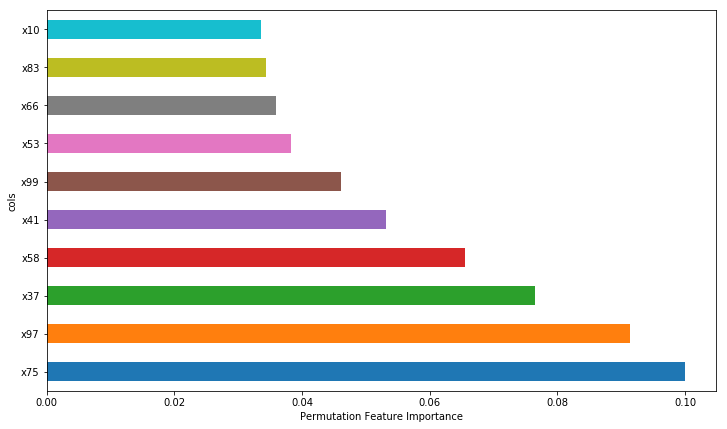

In [655]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(m, X_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

In [656]:
fi_permutation

cols       imp
0            x75  0.099922
1            x97  0.091335
2            x37  0.076503
3            x58  0.065574
4            x41  0.053084
5            x99  0.046058
6            x53  0.038251
7            x66  0.035909
8            x83  0.034348
9            x10  0.033568
10           x12  0.032006
11            x8  0.031226
12           x72  0.030445
13           x56  0.030445
14           x44  0.030445
15           x78  0.029664
16           x63  0.028884
17           x21  0.028103
18           x40  0.027322
19           x79  0.020297
20           x22  0.020297
21           x69  0.020297
22           x73  0.018735
23            x3  0.015613
24           x95  0.014052
25            x2  0.012490
26           x49  0.009368
27           x47  0.008587
28       x68_cat  0.006245
29           x15  0.005464
30       x41_cat  0.002342
31  x34_cat_type  0.001561
32  x34_cat_made  0.001561

**Time is out**

We see that ``x15``, which is one of the most uncorelated variables in the data set to our target with the rest of the categorical features that are at the bottom of importance. 

We are going to go ahead and say this method isn't going to work the best as we have already done a xgboost and NN that have better performance. RDF had good success, but the recall for this problem has struggled and I don't want to have a model that has a poor recall score. Even if that means we need to have models that might be slightly overfitted. 

### XGB

Why not lgb and cat? 

- With very few categorical variables we are going to see a marginal increase in predictive accuracy so this will not be something that I will use in this challenge. I would like to use one of them, but I am just not going to have time to implement them. 

- Addtionally, skipping the above method for xgb and will rely on the rdf model inference and variable importances to allow us to know, which variables aren't going to be used. 

In [689]:
import xgboost as xgb

In [698]:
df_raw = pd.read_pickle('tmp/dl_raw_data')
df_test = pd.read_pickle('tmp/dl_test_data')

In [699]:
third_reduction_columns = pd.read_csv('third_reduction_columns.csv', header=None);
to_keep = third_reduction_columns.iloc[:,0]

In [711]:
df= df_raw.copy()

In [712]:
df.shape

(40000, 101)

In [713]:
to_keep_y = to_keep.copy()
to_keep_y.loc[29] = 'y'

In [719]:
df_test = df_test[to_keep].copy()
df = df[to_keep_y].copy()

In [724]:
df_test.shape, df.shape

((10000, 29), (40000, 30))

In [727]:
#label encoding categorical variables 
train_cats(df)

In [729]:
#This split_data (prepares data for being split and scaling, imputation)
df_trn, y_trn, nas, mapper = split_data(df, 'y', do_scale=True)

In [732]:
X_test, _, _, _ = split_data(df_test, na_dict=nas, mapper=mapper, do_scale=True)

In [733]:
df_trn.shape

(40000, 57)

In [735]:
X_test.shape

(10000, 57)

In [737]:
df_trn = df_trn[to_keep].copy()
X_test = X_test[to_keep].copy() 

In [738]:
df_trn.shape, X_test.shape

((40000, 29), (10000, 29))

In [739]:
value_20_80 = int(len(df)*.20)

def split_vals(a,n): return a[:n], a[n:]
n_valid = value_20_80
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df, n_trn)

In [740]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((32000, 29), (32000,), (8000, 29), (8000,))

##### Modeling

In [741]:
model = xgb.XGBClassifier(base_score=0.8, colsample_bylevel=0.5, colsample_bytree=0.6, early_stopping_rounds=150,
                          gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=-1, 
                          objective='binary:logistic', silent=True, subsample=0.81)

eval_set  = [(X_train,y_train), (X_valid,y_valid)]
%time model.fit(X_train, y_train, eval_set= eval_set, eval_metric ='auc', early_stopping_rounds = 150)

[0]	validation_0-auc:0.736701	validation_1-auc:0.716207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 150 rounds.
[1]	validation_0-auc:0.822671	validation_1-auc:0.803805
[2]	validation_0-auc:0.863258	validation_1-auc:0.842995
[3]	validation_0-auc:0.880499	validation_1-auc:0.857843
[4]	validation_0-auc:0.890637	validation_1-auc:0.871588
[5]	validation_0-auc:0.899684	validation_1-auc:0.880991
[6]	validation_0-auc:0.904899	validation_1-auc:0.884971
[7]	validation_0-auc:0.908498	validation_1-auc:0.888756
[8]	validation_0-auc:0.915842	validation_1-auc:0.896333
[9]	validation_0-auc:0.917653	validation_1-auc:0.898461
[10]	validation_0-auc:0.918763	validation_1-auc:0.899919
[11]	validation_0-auc:0.922616	validation_1-auc:0.90311
[12]	validation_0-auc:0.925089	validation_1-auc:0.906132
[13]	validation_0-auc:0.928247	validation_1-auc:0.907918
[14]	validation_0-auc:0.93223	validation_1-auc:0.912299

[141]	validation_0-auc:0.988184	validation_1-auc:0.966994
[142]	validation_0-auc:0.988292	validation_1-auc:0.967079
[143]	validation_0-auc:0.988391	validation_1-auc:0.967133
[144]	validation_0-auc:0.988605	validation_1-auc:0.967447
[145]	validation_0-auc:0.988656	validation_1-auc:0.967504
[146]	validation_0-auc:0.988751	validation_1-auc:0.967657
[147]	validation_0-auc:0.98876	validation_1-auc:0.967672
[148]	validation_0-auc:0.988797	validation_1-auc:0.967635
[149]	validation_0-auc:0.988832	validation_1-auc:0.967674
[150]	validation_0-auc:0.988886	validation_1-auc:0.967655
[151]	validation_0-auc:0.988921	validation_1-auc:0.967663
[152]	validation_0-auc:0.989021	validation_1-auc:0.96777
[153]	validation_0-auc:0.989043	validation_1-auc:0.967813
[154]	validation_0-auc:0.989249	validation_1-auc:0.968025
[155]	validation_0-auc:0.989305	validation_1-auc:0.968088
[156]	validation_0-auc:0.989416	validation_1-auc:0.968128
[157]	validation_0-auc:0.989487	validation_1-auc:0.968206
[158]	validation

[283]	validation_0-auc:0.996205	validation_1-auc:0.975771
[284]	validation_0-auc:0.996246	validation_1-auc:0.975797
[285]	validation_0-auc:0.996291	validation_1-auc:0.975822
[286]	validation_0-auc:0.996312	validation_1-auc:0.975869
[287]	validation_0-auc:0.996349	validation_1-auc:0.97586
[288]	validation_0-auc:0.996396	validation_1-auc:0.976025
[289]	validation_0-auc:0.99644	validation_1-auc:0.976076
[290]	validation_0-auc:0.996469	validation_1-auc:0.976177
[291]	validation_0-auc:0.996504	validation_1-auc:0.976237
[292]	validation_0-auc:0.996505	validation_1-auc:0.976258
[293]	validation_0-auc:0.996514	validation_1-auc:0.976263
[294]	validation_0-auc:0.996591	validation_1-auc:0.976386
[295]	validation_0-auc:0.996615	validation_1-auc:0.976419
[296]	validation_0-auc:0.996621	validation_1-auc:0.976429
[297]	validation_0-auc:0.996685	validation_1-auc:0.976538
[298]	validation_0-auc:0.996731	validation_1-auc:0.976608
[299]	validation_0-auc:0.996788	validation_1-auc:0.976693
[300]	validation

[425]	validation_0-auc:0.999046	validation_1-auc:0.980143
[426]	validation_0-auc:0.999053	validation_1-auc:0.980173
[427]	validation_0-auc:0.99906	validation_1-auc:0.980135
[428]	validation_0-auc:0.999082	validation_1-auc:0.980187
[429]	validation_0-auc:0.999092	validation_1-auc:0.980202
[430]	validation_0-auc:0.999098	validation_1-auc:0.980211
[431]	validation_0-auc:0.999108	validation_1-auc:0.980213
[432]	validation_0-auc:0.99912	validation_1-auc:0.980203
[433]	validation_0-auc:0.999122	validation_1-auc:0.980199
[434]	validation_0-auc:0.999128	validation_1-auc:0.980193
[435]	validation_0-auc:0.999143	validation_1-auc:0.980222
[436]	validation_0-auc:0.999157	validation_1-auc:0.980215
[437]	validation_0-auc:0.999162	validation_1-auc:0.980208
[438]	validation_0-auc:0.99917	validation_1-auc:0.980247
[439]	validation_0-auc:0.999179	validation_1-auc:0.980228
[440]	validation_0-auc:0.999208	validation_1-auc:0.980309
[441]	validation_0-auc:0.999209	validation_1-auc:0.98034
[442]	validation_0

[567]	validation_0-auc:0.999867	validation_1-auc:0.98178
[568]	validation_0-auc:0.999872	validation_1-auc:0.981787
[569]	validation_0-auc:0.999874	validation_1-auc:0.981789
[570]	validation_0-auc:0.999877	validation_1-auc:0.981757
[571]	validation_0-auc:0.999878	validation_1-auc:0.98176
[572]	validation_0-auc:0.999878	validation_1-auc:0.981757
[573]	validation_0-auc:0.999878	validation_1-auc:0.981758
[574]	validation_0-auc:0.999879	validation_1-auc:0.981774
[575]	validation_0-auc:0.999879	validation_1-auc:0.981757
[576]	validation_0-auc:0.999879	validation_1-auc:0.981749
[577]	validation_0-auc:0.99988	validation_1-auc:0.981738
[578]	validation_0-auc:0.999884	validation_1-auc:0.981774
[579]	validation_0-auc:0.999885	validation_1-auc:0.981766
[580]	validation_0-auc:0.999887	validation_1-auc:0.981792
[581]	validation_0-auc:0.999887	validation_1-auc:0.981794
[582]	validation_0-auc:0.999889	validation_1-auc:0.981804
[583]	validation_0-auc:0.99989	validation_1-auc:0.981811
[584]	validation_0

[709]	validation_0-auc:0.999989	validation_1-auc:0.982106
[710]	validation_0-auc:0.999989	validation_1-auc:0.982094
[711]	validation_0-auc:0.999989	validation_1-auc:0.982097
[712]	validation_0-auc:0.99999	validation_1-auc:0.982102
[713]	validation_0-auc:0.99999	validation_1-auc:0.982121
[714]	validation_0-auc:0.999991	validation_1-auc:0.982154
[715]	validation_0-auc:0.999991	validation_1-auc:0.982154
[716]	validation_0-auc:0.999991	validation_1-auc:0.98218
[717]	validation_0-auc:0.999991	validation_1-auc:0.982197
[718]	validation_0-auc:0.999991	validation_1-auc:0.982182
[719]	validation_0-auc:0.999991	validation_1-auc:0.982175
[720]	validation_0-auc:0.999992	validation_1-auc:0.982192
[721]	validation_0-auc:0.999992	validation_1-auc:0.982199
[722]	validation_0-auc:0.999992	validation_1-auc:0.982211
[723]	validation_0-auc:0.999992	validation_1-auc:0.982198
[724]	validation_0-auc:0.999992	validation_1-auc:0.982211
[725]	validation_0-auc:0.999993	validation_1-auc:0.982201
[726]	validation_

[855]	validation_0-auc:1	validation_1-auc:0.982561
[856]	validation_0-auc:1	validation_1-auc:0.982581
[857]	validation_0-auc:1	validation_1-auc:0.982597
[858]	validation_0-auc:1	validation_1-auc:0.982585
[859]	validation_0-auc:1	validation_1-auc:0.982573
[860]	validation_0-auc:1	validation_1-auc:0.982577
[861]	validation_0-auc:1	validation_1-auc:0.98259
[862]	validation_0-auc:1	validation_1-auc:0.982592
[863]	validation_0-auc:1	validation_1-auc:0.982602
[864]	validation_0-auc:1	validation_1-auc:0.982589
[865]	validation_0-auc:1	validation_1-auc:0.982587
[866]	validation_0-auc:1	validation_1-auc:0.982586
[867]	validation_0-auc:1	validation_1-auc:0.982611
[868]	validation_0-auc:1	validation_1-auc:0.982602
[869]	validation_0-auc:1	validation_1-auc:0.9826
[870]	validation_0-auc:1	validation_1-auc:0.982589
[871]	validation_0-auc:1	validation_1-auc:0.982589
[872]	validation_0-auc:1	validation_1-auc:0.982594
[873]	validation_0-auc:1	validation_1-auc:0.982582
[874]	validation_0-auc:1	validatio

XGBClassifier(base_score=0.8, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, early_stopping_rounds=150, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.81)

##### Results

In [742]:
preds = model.predict(X_valid)

Accuracy For Each Class
[0.988533 0.835373]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6366
           1       0.95      0.84      0.89      1634

   micro avg       0.96      0.96      0.96      8000
   macro avg       0.95      0.91      0.93      8000
weighted avg       0.96      0.96      0.96      8000



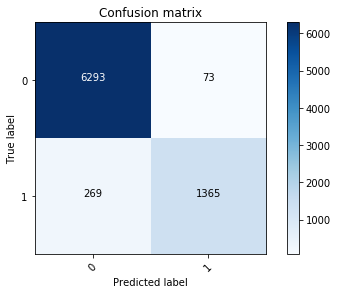

In [743]:
cm = confusion_matrix(y_valid, preds,)
plot_confusion_matrix(cm, np.unique(y_train))
print("Accuracy For Each Class")
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y_valid, preds))

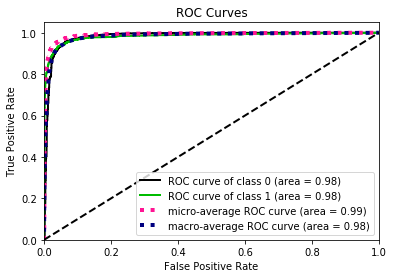

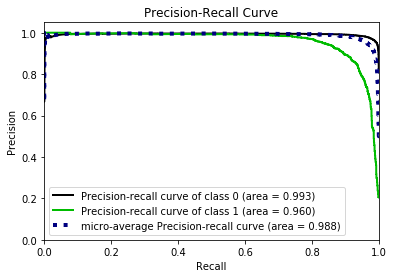

In [744]:
probs = model.predict_proba(X_valid)
skplt.metrics.plot_roc(y, probs);plt.show()
skplt.metrics.plot_precision_recall(y, probs);plt.show()

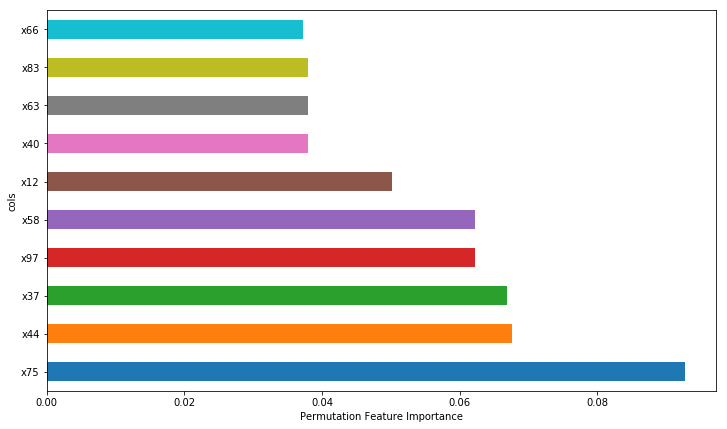

In [745]:
Y_valid = y_valid.copy()
Y_valid = pd.DataFrame(Y_valid)
fi_permutation = importances(model, X_valid, Y_valid)
fi_permutation['Importance'] = fi_permutation["Importance"]/fi_permutation["Importance"].sum()
fi_permutation = (fi_permutation
                  .reset_index()
                  .rename({'Feature':'cols', 'Importance':'imp'},axis=1))
plot_fi(fi_permutation[:10], False, 'Permutation')

**Note** 
``x75`` is there again the top variable

##### Getting Test Results

In [746]:
from sklearn.externals import joblib
joblib_file = "tmp/StateFarm35_XGB.pkl"
# joblib.dump(m, joblib_file)

In [747]:
#load
joblib_file = "tmp/StateFarm35_RDF.pkl"
joblib_model = joblib.load(joblib_file)

In [749]:
probs = model.predict_proba(X_test)
preds = model.predict(X_test)

In [751]:
pd.value_counts(preds, normalize=True)

0    0.8171
1    0.1829
dtype: float64

In [ ]:
df_test['Prediction_Probs'] = test_preds[0].data.numpy().T[0]
df_test['Prediction'] = test_preds[0].argmax(1).numpy()

In [757]:
predictions = probs.T[0]

In [759]:
df_submission_xgb = pd.DataFrame({'Probabilities': predictions}); df_submission_xgb.head()

Probabilities
0       0.994684
1       0.999857
2       0.992220
3       0.032220
4       0.999962

In [760]:
df_submission_xgb.to_csv('State_Farm_XGB_Submission.csv')

##### Hyper Parameter Search

In [428]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [429]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [440]:
params = {
        'base_score' : [.50,.80],
        'min_child_weight': [1, 2, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'colsample_bylevel':[0.5, 0.6, 0.9],
        'learning_rate':[0.1, 0.4, .01, 0.2],
        'scale_pos_weight':[1, 0.8, 0.6, 0.3],
        'max_depth': [3, 4, 5, 6, 10]
        }

In [441]:
model = XGBClassifier(n_estimators=1000, silent=True, early_stopping_rounds = 150, n_jobs=-1)

In [442]:
folds = 10
param_comb = 50

skf = StratifiedKFold(n_splits=folds, shuffle=True)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='roc_auc',
                                    n_jobs=-1, cv=skf, verbose=3)

# grid = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf, verbose=3)

In [443]:
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 47.1min finished



 Time taken: 0 hours 47 minutes and 16.62 seconds.


In [1]:
# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# #print(random_search.best_score)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)
# results.to_csv(f'{PATH}xgb-random-grid-search-results-02.csv', index=False)

## Baseline Model (DL Apporach)

**Quick and Dirty Approach** 

- Things to add 

    * Features created
    * Using model inference to reduce dimensionality from RDF and check the differences and not just run to see.
    * Increase drop out and discriminative learning rates

Admittedly, I should have started with DL, but ML has a soft spot in my heart, and I spend a lot of time with the ML side. There is room to improve this model, but this is a coding challenge and there is a lot of fact checking and further digging into the data that would have been done with more time. 

In [455]:
from fastai.tabular import *

In [457]:
df_raw = pd.read_pickle('tmp/dl_raw_data')
df_test = pd.read_pickle('tmp/dl_test_data')

In [458]:
df_raw.shape, df_test.shape

((40000, 101), (10000, 100))

In [459]:
dep_var = 'y'
cat_vars = ['x34', 'x35', 'x68', 'x93']
cont_vars = ['x0','x1','x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19','x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28','x29', 'x30','x31', 'x32', 'x33', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46','x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55','x56', 'x57', 'x58', 'x59', 'x60','x61', 'x62', 'x63', 'x64','x65', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73','x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82','x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90','x91','x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99']
procs=[FillMissing, Categorify, Normalize]

In [460]:
display_all(df_raw.head())

x0         x1         x2         x3         x4         x5        x6  \
0  10.142889 -15.675620   3.583176 -22.397489  27.221894 -34.110924 -0.072829   
1 -52.214630   5.847135 -10.902843 -14.132351  20.588574  36.107322  0.115023   
2  67.718500   2.064334  12.394186 -18.667102  47.465504 -50.373658  0.253707   
3 -28.003111   8.565128  -8.592092   5.918960  -3.224154  78.315783 -0.879845   
4  80.703016  30.736353 -30.101857 -21.201140 -91.946233 -47.469246 -0.646831   

         x7        x8        x9       x10       x11        x12       x13  \
0 -0.544444  0.997601 -2.691778 -0.923879  8.109456  27.872550 -3.420582   
1  0.276093 -0.699168 -0.972708  1.287131  5.717183  -3.761334 -5.074973   
2  1.068968  2.939713  2.691218  3.058585  7.537863 -19.130709 -0.906646   
3  1.176889 -2.414752  0.589646 -0.906179  0.087087  25.075633 -0.834239   
4 -0.578398  0.980849 -1.426112  0.363235  5.836213  29.396618 -2.591986   

        x14       x15        x16       x17        x18        x19        x20  \
0  1.511710  6.673493  -4.323289 -1.538177  12.853393 -23.583975 -26.410490   
1 -1.296964 -2.366536 -19.532219 -0.651274  -0.758730  -5.580162  47.151801   
2 -2.794020 -3.978507  14.237849  1.373681   9.635405 -16.183555  16.922392   
3 -0.027757  3.708857 -12.314642  2.700113   7.216934  74.438816  61.764811   
4 -1.555760  4.963425   3.703779 -0.010266  -2.837060  48.985375  23.961394   

        x21        x22        x23        x24        x25       x26        x27  \
0  2.328126 -28.226474  -4.131820   0.268103  -5.661808 -2.782330  30.276359   
1  2.053410  -4.348193 -17.632414  -3.963233 -27.385429  1.991331  25.995571   
2  1.663092  -9.758591 -13.040577 -13.865584   4.965384  0.940166  16.305724   
3 -1.605895 -15.125777   5.556041   4.593257 -16.996278 -3.875344   5.064833   
4  4.685315  21.758491   1.466513  -3.417453  45.498835  4.821398  35.093986   

        x28       x29       x30       x31       x32        x33     x34  x35  \
0 -0.944980  0.277266 -2.233740  0.515763  0.004137 -27.321975     bmw  wed   
1 -1.390032 -0.791795  2.537591 -1.138456 -1.202222  48.491336  nissan  thu   
2  0.112402 -1.199571  1.286813  0.277410  0.682253  -6.741030   honda  wed   
3 -1.296087  1.630619 -4.694258 -0.722119 -1.689241 -20.987787  toyota  thu   
4  4.404143  1.387974 -4.123902  2.092002 -0.005312 -65.261291     bmw  thu   

        x36       x37       x38       x39        x40     x41         x42  \
0  5.613605 -8.771422  1.012030 -2.122949   0.500782  -54.10  -60.377200   
1 -2.132043  1.288928 -1.622637 -0.919865   9.054563 -229.32 -280.208298   
2  3.206642 -8.065741  0.838277 -0.465169   1.225612  243.68 -119.470071   
3 -3.589886  4.368415 -1.045650  1.613660  -4.185118  126.15  129.270157   
4  9.953264  4.303842  0.632836  1.657977  10.945454  877.39 -319.428734   

         x43         x44   x45       x46        x47       x48        x49  \
0 -14.343129  -38.244485  0.00 -8.346880   0.300698 -3.560418 -29.858649   
1 -46.045485   -7.783574  0.01 -2.248960  15.868349 -2.320347  29.611460   
2  25.462689   56.571522  0.01 -2.161725   7.287187 -2.414766 -19.325576   
3  13.413693  115.018748  0.02  4.206076 -40.254305  0.049048  28.853906   
4   9.194313  -89.678180  0.02  1.189501   4.036919  0.296720 -34.969908   

        x50       x51       x52        x53        x54       x55        x56  \
0 -0.004122 -1.034268  2.280323  -9.220175  -0.672959 -1.352266  19.547038   
1  0.035378 -9.960903  0.662594 -40.051587  -7.467978  0.150334  13.798547   
2  0.865352 -8.971459  0.182888  25.383424  -4.359127 -0.198638   3.231385   
3  0.263934  7.778529  3.748663  -1.119398 -13.652775  0.339680  -8.812638   
4 -0.490233 -2.936929  1.080471  15.078833   6.662614  0.411686  -0.192318   

         x57        x58       x59       x60        x61       x62       x63  \
0  -6.706483 -16.123533 -5.271198  0.099280  -4.905632  0.557732 -3.858105   
1 -19.627385 -28.046366 -8.330669  0.014509  -3.445528  0.109443 -4.855778   
2 -34.887447 -19.6

In [461]:
value_20_80 = int(len(df_raw)*.20)

In [462]:
valid_idx = (list(df_raw[-8000:].index.values))

In [463]:
train_idx = df_raw.drop(valid_idx).index

In [464]:
len(train_idx), len(valid_idx)

(32000, 8000)

In [465]:
# verify that target is still the same as rdf
df_raw.iloc[valid_idx].y.sum() / len(valid_idx) , df_raw.y.sum() / len(df_raw)

(0.20425, 0.201175)

In [466]:
to_keep_dl_train = df_raw.columns.values
to_keep_dl_train = pd.DataFrame(to_keep_dl_train)
to_keep_dl_train = to_keep_dl_train.iloc[:,0]

In [467]:
to_keep_dl_test = df_test.columns.values
to_keep_dl_test = pd.DataFrame(to_keep_dl_test)
to_keep_dl_test = to_keep_dl_test.iloc[:,0]

In [468]:
cat_vars = ['x34', 'x35', 'x68', 'x93']
cont_vars = ['x0','x1','x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19','x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28','x29', 'x30','x31', 'x32', 'x33', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46','x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55','x56', 'x57', 'x58', 'x59', 'x60','x61', 'x62', 'x63', 'x64','x65', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73','x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82','x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90','x91','x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99']
dep_var = ['y']
for c in cont_vars:
    df_raw[c] = df_raw[c].astype('float32')
    df_test[c] = df_test[c].astype('float32')
    
for c in cat_vars: 
    df_raw[c] = df_raw[c].astype('str')
    df_test[c] = df_test[c].astype('str') 

In [469]:
train_cats(df_raw)
apply_cats(df_test, df_raw)
df_raw_clean, _, nas = split_data(df_raw)
df_test_clean, _, _ = split_data(df_test, na_dict=nas)

In [470]:
third_reduction_columns = pd.read_csv('third_reduction_columns.csv', header=None);
to_keep = third_reduction_columns.iloc[:,0]

In [471]:
len(to_keep)

29

In [472]:
to_keep.loc[29] = 'x34'
to_keep.loc[30] = 'x35'
to_keep.loc[31] = 'x68'
to_keep.loc[32] = 'x93'

In [473]:
to_keep_y = to_keep.copy()
to_keep_y.loc[33] = 'y'

In [474]:
df_raw_clean = df_raw_clean[to_keep_y]
df_test_clean = df_test_clean[to_keep]

In [442]:
#full data set
df_raw_clean = df_raw_clean[to_keep_dl_train]
df_test_clean = df_test_clean[to_keep_dl_test]

In [444]:
display_all(df_test_clean.head())

x0         x1         x2         x3         x4         x5  \
0  -23.230885  -1.809757  12.380690  -4.101199 -60.760750 -22.957453   
1  138.561417   1.107473 -19.781010 -17.584757 -76.922112  71.816826   
2   -9.243047 -10.207303  -7.507803   3.152110 -14.915059  30.576214   
3    8.963713  17.580528  13.884171 -17.164185 -33.547539  19.288187   
4   27.431028  -6.232849  52.780834  -7.053903   5.679193 -29.618139   

         x6        x7        x8        x9       x10        x11        x12  \
0 -1.964078 -0.631029 -4.306616 -4.694199  0.984161  -7.813357  -8.948981   
1 -0.418432  1.403957 -5.367051  0.039857  5.540313  -8.553155 -38.290520   
2 -0.378178  2.606353  1.581679  4.802973  1.516739  11.055875 -54.572895   
3 -1.219019  5.574611 -3.879657  2.693111  1.793155   7.615984 -26.734970   
4  1.331833  4.425692 -4.213257 -0.398755  1.094204   2.091466  43.716057   

        x13       x14        x15        x16       x17        x18        x19  \
0 -5.765388 -1.176939   4.845660  -4.285791  0.962268  -0.430889 -51.678505   
1  5.006972  3.055414   1.833679   3.294067 -0.275436   8.495518  40.080585   
2  6.127508  1.837907   2.510477 -23.299011  1.287312  -2.823371  -8.083631   
3  5.302607  0.870665  -7.508497  17.594910  0.556339   4.020171   8.438701   
4  1.470203 -1.332571  12.880681   7.520478  0.092574  11.559201  -8.050503   

         x20       x21        x22        x23        x24        x25       x26  \
0  20.850698 -1.437369  49.015652   3.099665  25.023184   9.434083  1.054177   
1  26.904978  3.865803 -18.938877  -6.536682  -7.168618 -14.732338 -1.726570   
2   9.234985 -0.442053 -26.197193 -11.446151  16.932831 -16.076624 -2.094705   
3   3.274892  0.641188  -9.068538  -2.828128  -3.756223  13.528811 -8.821194   
4 -16.324610  1.813721  10.244716   4.116623  -2.696492 -30.644926 -7.333009   

         x27       x28       x29       x30       x31       x32        x33  \
0   1.856877 -2.319116  0.873665  2.894285  1.979280 -0.797418   6.036331   
1  20.365429 -3.336198 -2.708674  1.073712 -0.181030 -0.552745 -86.946899   
2  11.290329 -1.440966  1.241340  8.822058  0.554444 -0.209683 -29.853437   
3   4.826253 -4.764253 -0.947258 -3.327475  1.334167 -0.205648  18.474939   
4  50.055183  2.170301  1.466586  3.346253 -0.462526 -0.928480 -14.854651   

   x34  x35        x36        x37       x38       x39        x40          x41  \
0   11    6   6.690169  17.200291 -1.507259 -1.321624   4.677756 -1073.609985   
1   11    4  12.792377  12.052661 -1.531194  0.144940 -12.090316  1775.770020   
2   10    5   0.801329  14.942918  0.610799  0.674660  -6.855244   697.229980   
3   11    6   0.745132   1.296986 -1.740376  2.453689 -17.632793  -134.479996   
4   10    5  -1.952042  11.936637 -0.790034 -1.016620   0.899595  1195.160034   

          x42        x43         x44   x45       x46        x47       x48  \
0   33.619289  15.568095 -130.246323  0.01  1.330136  21.377153 -0.672954   
1 -301.688782   6.324883 -295.644318  0.01 -2.394215  30.463881  0.576090   
2   57.189720  -1.998973   10.743149  0.00  1.800921   6.157279  0.174626   
3 -124.182930 -14.303372 -126.122292  0.02  4.328307  -5.253210 -0.177297   
4   25.023754  13.947048  -27.749239  0.00 -1.466027 -21.390398  0.668820   

         x49       x50        x51       x52        x53       x54       x55  \
0 -21.009945 -0.751394  -1.825256  1.139844  -6.252494  0.409941  0.524772   
1  37.375381 -0.840005  -4.768371 -3.431296  21.072638 -2.013523 -0.221913   
2  -4.130499  0.202873   5.841817  5.152410  16.533539 -9.036248  0.339615   
3 -17.192049 -0.309572  17.169415 -2.172213  32.426407  2.486255 -1.610325   
4   9.421375  0.391959  -5.080109  5.033026  17.274458 -3.927965  0.363830   

        x56        x57        x58        x59       x60        x61       x62  \
0 -2.200340  -4.032222   5.090105   6.091427 -0.381573   5.002840 -3.897192   
1 -5.204623 -26.039917  -9.409815  -4.080770  0.865505  -6.988809 -5.661018   
2  9.997577  33.614342  18.952780   6.09

In [475]:
BATCH_SIZE = 128

In [476]:
df_raw_clean.columns.values

array(['x75', 'x37', 'x97', 'x58', 'x53', 'x66', 'x41', 'x44', 'x99', 'x12', 'x21', 'x72', 'x56', 'x3', 'x10', 'x79',
       'x40', 'x73', 'x83', 'x2', 'x78', 'x8', 'x63', 'x22', 'x47', 'x69', 'x49', 'x95', 'x15', 'x34', 'x35', 'x68',
       'x93', 'y'], dtype=object)

In [477]:
#For RDF Inference DL Approach
cat_vars = ['x34', 'x35', 'x68', 'x93']
cont_vars = ['x75', 'x37', 'x97', 'x58', 'x53', 'x66', 'x41', 'x44', 'x99', 'x12', 'x21', 'x72', 'x56', 'x3', 'x10', 'x79','x40', 'x73', 'x83', 'x2', 'x78', 'x8', 'x63', 'x22', 'x47', 'x69', 'x49', 'x95', 'x15', ]
dep_var = ['y']

In [478]:
data = (TabularList.from_df(df_raw_clean, path = '.', cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .add_test(TabularList.from_df(df_test_clean, path = '.', cat_names=cat_vars, cont_names=cont_vars))
                .databunch(bs=BATCH_SIZE))

#### Modeling 

In [479]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

In [480]:
class roc(Callback):
    '''
    Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.total/self.batch_count)

In [481]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [490]:
learner = tabular_learner(data, layers=[1000,500],ps=[0.001,0.01],metrics= [accuracy,dice], callback_fns=[ShowGraph, AUROC])
def getLearner():
    return tabular_learner(data, layers=[1000,500],ps=[0.001,0.01], 
                           metrics= [accuracy,dice], callback_fns=[ShowGraph, AUROC])
learner = getLearner()

In [491]:
#Arch
learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(7, 5)
    (2): Embedding(14, 7)
    (3): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=51, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [492]:
# Use Lr_find with different weight decays and record all the losses 
# Iters is by default == 100
# This could be to low and might have to much variance so you can play with it
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


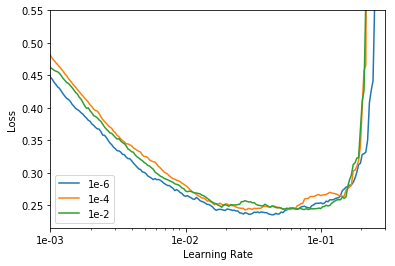

In [493]:
# Plotting The Above WD
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55

for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')

#ax range may need some tuning wiht different archs
ax.set_xlim((1e-3, 3e-1))
ax.set_ylim((min_y - 0.02, max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

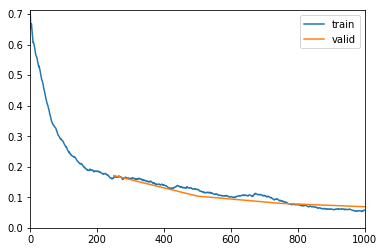

In [494]:
lr = 2e-2
wd = 1e-2
#full data set
# learner.fit_one_cycle(cyc_len=3, max_lr=lr, wd=wd)
learner.fit_one_cycle(cyc_len=4, max_lr=lr, wd=wd)

In [495]:
preds, y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9802500009536743 %.


Accuracy Score Per Class
[0.98139  0.975515]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6366
           1       0.98      0.93      0.95      1634

   micro avg       0.98      0.98      0.98      8000
   macro avg       0.98      0.96      0.97      8000
weighted avg       0.98      0.98      0.98      8000



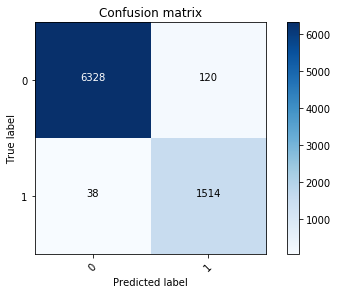

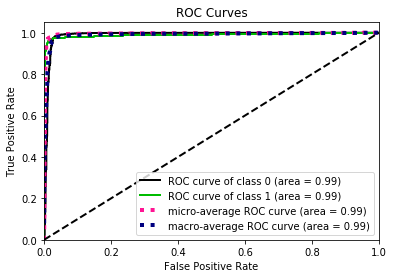

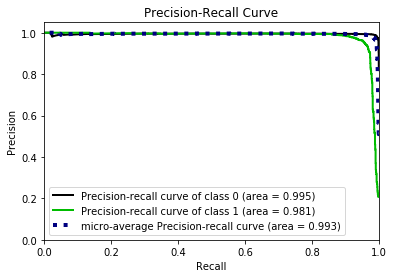

In [496]:
#change to predictions not probabilities
pred = preds.argmax(1)

cm = confusion_matrix(pred, y)
plot_confusion_matrix(cm, np.unique(y))
print('Accuracy Score Per Class')
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y, pred))
skplt.metrics.plot_roc(y, preds);plt.show()
skplt.metrics.plot_precision_recall(y, preds);plt.show()

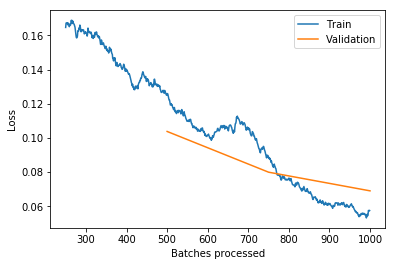

In [497]:
#slightly over fitting, but we don't want to underfit either
#adding some drop out might help, but will not be doing that for this challenge
learner.recorder.plot_losses(last=-1)

In [498]:
rdfname = f'tabular_model_rdfinference'

In [499]:
learner.save(rdfname)

In [3]:
#Load data set 
# learner.load('tabular_model_rdfinference')

In [501]:
#Predictions
test_preds = learner.get_preds(DatasetType.Test)

In [502]:
df_test['Prediction_Probs'] = test_preds[0].data.numpy().T[0]
df_test['Prediction'] = test_preds[0].argmax(1).numpy()

In [503]:
pd.value_counts(df_test.Prediction, normalize=True)

0    0.8033
1    0.1967
Name: Prediction, dtype: float64

In [504]:
submission_dl_rdf = df_test['Prediction_Probs']
submission_dl_rdf = pd.DataFrame({'Probabilites':submission_dl_rdf})
submission_dl.to_csv('StateFarm_DLRDFINF_Submission.csv', index=False)

We can see here that we do much better with the DL approach compared to the ML and DL approach. This is with the same columns besides the categorical variables that implementations of categorical variables in sklearn and most other libraries outside of H20 struggles with splitting label encoded variables. 

I wanted to show that our model can do very very well with less parameters, but we aren't over fitting with the full data set and I am going to rely on the full data set with regularization we tend to see great extraploation in the field of practice. 

What I would want to do is deploy my best models and run all of them on the incoming data and lead to an ensemble and a/b testing method to see which model is doing the best. 

**Full Data Set**

In [421]:
#Full Data Set
name = f'tabular_model_noslice'

In [269]:
learner.save('modeltabular_model_noslice.pth)

In [2]:
#Load ndata set 
# learner.load('tabular_model_noslice')

In [451]:
preds, y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9926249980926514 %.


Accuracy Score Per Class
[0.993428 0.989434]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6366
           1       0.99      0.97      0.98      1634

   micro avg       0.99      0.99      0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



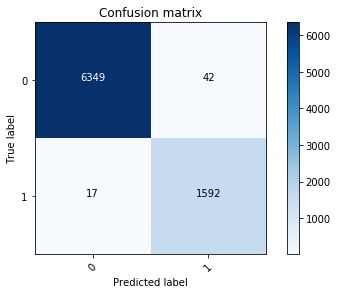

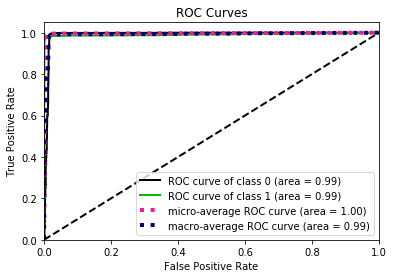

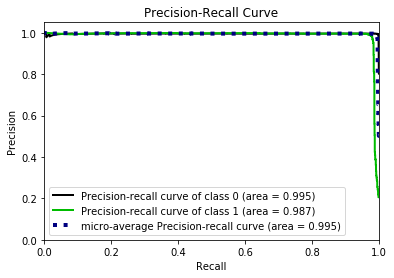

In [454]:
#change to predictions not probabilities
pred = preds.argmax(1)

cm = confusion_matrix(pred, y)
plot_confusion_matrix(cm, np.unique(y))
print('Accuracy Score Per Class')
print(cm.diagonal()/cm.sum(axis=1))
print(classification_report(y, pred))
skplt.metrics.plot_roc(y, preds);plt.show()
skplt.metrics.plot_precision_recall(y, preds);plt.show()

In [271]:
#Predictions
test_preds = learner.get_preds(DatasetType.Test)

In [276]:
len(test_preds[0])

10000

In [296]:
df_test['Prediction_Probs'] = test_preds[0].data.numpy().T[0]
df_test['Prediction'] = test_preds[0].argmax(1).numpy()

In [301]:
display_all(df_test.head())

x0         x1         x2         x3         x4         x5  \
0  -23.230885  -1.809757  12.380690  -4.101199 -60.760750 -22.957453   
1  138.561417   1.107473 -19.781010 -17.584757 -76.922112  71.816826   
2   -9.243047 -10.207303  -7.507803   3.152110 -14.915059  30.576214   
3    8.963713  17.580528  13.884171 -17.164185 -33.547539  19.288187   
4   27.431028  -6.232849  52.780834  -7.053903   5.679193 -29.618139   

         x6        x7        x8        x9       x10        x11        x12  \
0 -1.964078 -0.631029 -4.306616 -4.694199  0.984161  -7.813357  -8.948981   
1 -0.418432  1.403957 -5.367051  0.039857  5.540313  -8.553155 -38.290520   
2 -0.378178  2.606353  1.581679  4.802973  1.516739  11.055875 -54.572895   
3 -1.219019  5.574611 -3.879657  2.693111  1.793155   7.615984 -26.734970   
4  1.331833  4.425692 -4.213257 -0.398755  1.094204   2.091466  43.716057   

        x13       x14        x15        x16       x17        x18        x19  \
0 -5.765388 -1.176939   4.845660  -4.285791  0.962268  -0.430889 -51.678505   
1  5.006972  3.055414   1.833679   3.294067 -0.275436   8.495518  40.080585   
2  6.127508  1.837907   2.510477 -23.299011  1.287312  -2.823371  -8.083631   
3  5.302607  0.870665  -7.508497  17.594910  0.556339   4.020171   8.438701   
4  1.470203 -1.332571  12.880681   7.520478  0.092574  11.559201  -8.050503   

         x20       x21        x22        x23        x24        x25       x26  \
0  20.850698 -1.437369  49.015652   3.099665  25.023184   9.434083  1.054177   
1  26.904978  3.865803 -18.938877  -6.536682  -7.168618 -14.732338 -1.726570   
2   9.234985 -0.442053 -26.197193 -11.446151  16.932831 -16.076624 -2.094705   
3   3.274892  0.641188  -9.068538  -2.828128  -3.756223  13.528811 -8.821194   
4 -16.324610  1.813721  10.244716   4.116623  -2.696492 -30.644926 -7.333009   

         x27       x28       x29       x30       x31       x32        x33  \
0   1.856877 -2.319116  0.873665  2.894285  1.979280 -0.797418   6.036331   
1  20.365429 -3.336198 -2.708674  1.073712 -0.181030 -0.552745 -86.946899   
2  11.290329 -1.440966  1.241340  8.822058  0.554444 -0.209683 -29.853437   
3   4.826253 -4.764253 -0.947258 -3.327475  1.334167 -0.205648  18.474939   
4  50.055183  2.170301  1.466586  3.346253 -0.462526 -0.928480 -14.854651   

          x34  x35        x36        x37       x38       x39        x40  \
0  volkswagon  wed   6.690169  17.200291 -1.507259 -1.321624   4.677756   
1  volkswagon  thu  12.792377  12.052661 -1.531194  0.144940 -12.090316   
2      toyota  tue   0.801329  14.942918  0.610799  0.674660  -6.855244   
3  volkswagon  wed   0.745132   1.296986 -1.740376  2.453689 -17.632793   
4      toyota  tue  -1.952042  11.936637 -0.790034 -1.016620   0.899595   

           x41         x42        x43         x44   x45       x46        x47  \
0 -1073.609985   33.619289  15.568095 -130.246323  0.01  1.330136  21.377153   
1  1775.770020 -301.688782   6.324883 -295.644318  0.01 -2.394215  30.463881   
2   697.229980   57.189720  -1.998973   10.743149  0.00  1.800921   6.157279   
3  -134.479996 -124.182930 -14.303372 -126.122292  0.02  4.328307  -5.253210   
4  1195.160034   25.023754  13.947048  -27.749239  0.00 -1.466027 -21.390398   

        x48        x49       x50        x51       x52        x53       x54  \
0 -0.672954 -21.009945 -0.751394  -1.825256  1.139844  -6.252494  0.409941   
1  0.576090  37.375381 -0.840005  -4.768371 -3.431296  21.072638 -2.013523   
2  0.174626  -4.130499  0.202873   5.841817  5.152410  16.533539 -9.036248   
3 -0.177297 -17.192049 -0.309572  17.169415 -2.172213  32.426407  2.486255   
4  0.668820   9.421375  0.391959  -5.080109  5.033026  17.274458 -3.927965   

        x55       x56        x57        x58        x59       x60        x61  \
0  0.524772 -2.200340  -4.032222   5.090105   6.091427 -0.381573   5.002840   
1 -0.221913 -5.204623 -26.039917  -9.409815  -4.080770  0.865505  -6.988809   
2  0.339615  9.997577  33.614342  18.952780   6.091787  1.

In [307]:
#This is a good sign that our population is being predicted the same as the hold out and training
#This could also be a sign of overfitting, but I am going to say this is a good thing
pd.value_counts(df_test.Prediction, normalize=True)

0    0.7937
1    0.2063
Name: Prediction, dtype: float64

In [302]:
submission_dl = df_test['Prediction_Probs']

In [306]:
submission_dl = pd.DataFrame({'Probabilites':submission_dl})

In [308]:
submission_dl.to_csv('StateFarm_DL_Submission.csv', index=False)